# **Ejercicio series de tiempo**

## **Librerías y módulos necesarios**

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime
from scipy.stats import shapiro
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt
from statsmodels.tsa import seasonal
from sklearn.metrics import r2_score
from yahoo_fin.stock_info import get_data
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# **Descriptivo del conjunto de datos**

## **Datos**: **Banco Davivienda S.A.**

En este ejercicio se estará trabajando con un conjunto de datos del banco **Davivienda**.

In [2]:
ticker = 'PFDAVVNDA.CL' # Código alfanumérico (etiqueta de la base de datos)
resolution = '1d' # Muestra los datos diarios
end_date = datetime.now()
start_date = '01-01-2023'


In [3]:
data = get_data(ticker, start_date = start_date, end_date = end_date, interval = resolution, index_as_date = False)
data.drop('ticker', axis = 1, inplace = True)

## **Características de los datos**

In [4]:
data.head()

,date,open,high,low,close,adjclose,volume
0,2023-01-02,27560.0,27560.0,27080.0,27080.0,25756.806641,34003.0
1,2023-01-03,27040.0,27150.0,27040.0,27150.0,25823.386719,5334.0
2,2023-01-04,27150.0,27210.0,27150.0,27210.0,25880.455078,6130.0
3,2023-01-05,27300.0,27780.0,27300.0,27750.0,26394.070312,5680.0
4,2023-01-06,27800.0,28700.0,27800.0,28700.0,27297.650391,49937.0


In [5]:
data.tail()

,date,open,high,low,close,adjclose,volume
441,2024-09-10,17440.0,17480.0,17440.0,17480.0,17480.0,3067.0
442,2024-09-11,17480.0,17700.0,17620.0,17620.0,17620.0,17471.0
443,2024-09-12,17620.0,18200.0,17640.0,18200.0,18200.0,63369.0
444,2024-09-13,18200.0,18400.0,18200.0,18340.0,18340.0,27826.0
445,2024-09-16,18340.0,18680.0,18400.0,18680.0,18680.0,31956.0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 446 entries, 0 to 445
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      446 non-null    datetime64[ns]
 1   open      438 non-null    float64       
 2   high      438 non-null    float64       
 3   low       438 non-null    float64       
 4   close     438 non-null    float64       
 5   adjclose  438 non-null    float64       
 6   volume    438 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 24.5 KB


In [7]:
data.shape

(446, 7)

In [8]:
data.describe()

,date,open,high,low,close,adjclose,volume
count,446,438.000000,438.000000,438.000000,438.000000,438.000000,4.380000e+02
mean,2023-11-08 16:50:34.977578240,20075.196780,20229.009565,19873.278971,20066.665614,19739.219642,9.196979e+05
min,2023-01-02 00:00:00,15420.000000,15600.000000,15340.000000,15340.000000,15340.000000,0.000000e+00
25%,2023-06-06 06:00:00,18200.000000,18265.000000,17955.000000,18185.000000,17868.248047,8.950000e+03
50%,2023-11-08 12:00:00,19900.000000,20000.000000,19800.000000,19900.000000,19682.403320,2.419400e+04
75%,2024-04-11 18:00:00,21430.000000,21600.000000,21000.000000,21460.000000,21000.000000,5.561825e+04
max,2024-09-16 00:00:00,28700.000000,29000.000000,28700.000000,29000.000000,27582.990234,3.673912e+08
std,NaN,2882.902854,2918.152386,2828.240839,2903.898329,2588.100021,1.755349e+07


Nótese que luego de analizar las principales características de los datos podemos deducir que cuenta con 445 observaciones y 7 columnas, de las cuales todas son de tipo numérico y la fecha está asignada como un datetime. La fecha de inicio de los datos es **01-01-2023** y la fecha final de los datos es **13-09-2024**.

## **Comportamiento de la serie**

En este caso se visualizarán los datos por medio de una serie de tiempo. Por lo tanto es importante conocer el comportamiento inicial de la serie.

Los lags son los retrasos o desfases en una serie temporal, que representan el valor de la variable en momentos previos utilizados para analizar la relación con el valor actual.

In [9]:
if data['adjclose'].isnull().sum() > 0:
    data['adjclose'] = data['adjclose'].fillna(method = 'ffill')
    # Llena los nulos con el valor anterior más cercano en la columna (método de "forward fill"), propagando los últimos valores no nulos hacia adelante.

plt.rcParams['figure.figsize'] = (8, 4)

En el siguiente gráfico, se observa la serie de tiempo correspondiente al precio de cierre ajustado de la acción de Davivienda a lo largo del tiempo anteriormente ya mencionado.

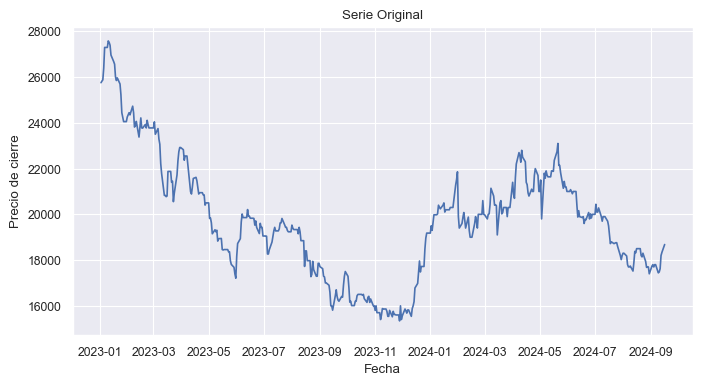

In [10]:
# Serie original
sns.set_theme()
sns.set_context("paper")
sns.lineplot(data = data, x = data.date, y = data.adjclose);
plt.title('Serie Original')
plt.xlabel('Fecha')
plt.ylabel('Precio de cierre')
plt.show()

En la gráfica se observa una caída brusca en el precio al inicio del periodo, seguida de variaciones con una tendencia a la baja hasta finales de 2023. A partir de 2024, los precios muestran mayor volatilidad con algunos picos, aunque se mantiene la tendencia descendente. La serie temporal indica que los precios de la acción han experimentado cambios significativos, con una pérdida de valor general a lo largo del tiempo. Dada la variabilidad observada, parece que esta serie **NO** es estacionaria, ya que no muestra estabilidad a lo largo del periodo.

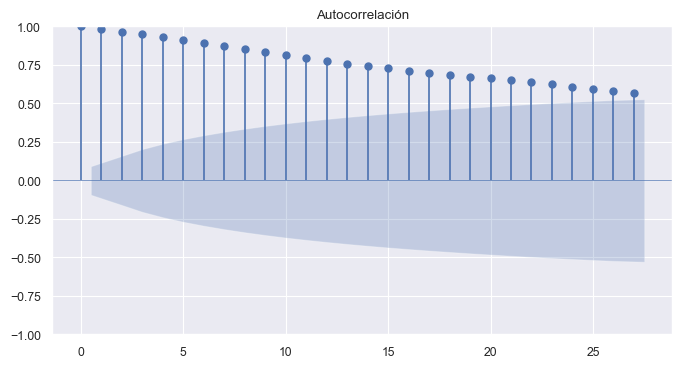

In [11]:
# Autocorrelación
# Lag: observación de una variable en un momento anterior al momento actual.
plot_acf(data['adjclose'], linewidth = 0.5)
plt.title('Autocorrelación')
plt.show()

La gráfica de autocorrelación muestra que los primeros lags tienen una autocorrelación alta, lo que indica que los valores de la serie están fuertemente correlacionados en intervalos de tiempo cercanos. A medida que aumenta el número de lags, la autocorrelación disminuye de manera gradual, lo que sugiere que los valores más alejados en el tiempo tienen una relación más débil. Nótese que la mayoría de barras caen sobre la zona sombreada lo que indica que la correlación en estos valores NO es significativa.

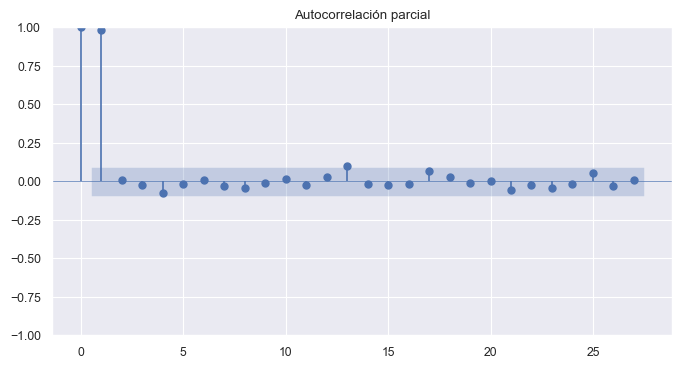

In [12]:
# Autocorrelación Parcial
plot_pacf(data['adjclose'], linewidth = 0.5)
plt.title('Autocorrelación parcial')
plt.show()

La gráfica de autocorrelación parcial muestra que la relación entre el último día y el día anterior es bastante alta, casi perfecta, lo que sugiere una fuerte dependencia entre estos valores consecutivos. Sin embargo, a medida que se incrementan los lags, la autocorrelación parcial disminuye rápidamente, y los días posteriores muestran correlaciones muy bajas y poco significativas.

### **Test de Dickey-Fuller.**

En esta parte se usará la prueba de `Dickey-Fuller` para verificar si la serie de tiempo es estacionaria o no.

- **Hipótesis Nula (H₀):** La serie de tiempo es NO estacionaria (tiene una raíz unitaria)
- **Hipótesis Alternativa (H₁):** La serie de tiempo es estacionaria (no tiene una raíz unitaria)

In [13]:
adf_result = adfuller(data["adjclose"].tolist())
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])

ADF Statistic: -2.412431
p-value: 0.138259


Dado que el p-valor (`0.14`) es mayor que el nivel de significancia (`0.05`) entonces NO rechazamos la hipótesis nula y por tanto se afirma está misma. Es decir, la serie de tiempo NO es estacionaria.

### **Descomposición de la serie**

La descomposición de una serie temporal permite separar sus componentes principales: tendencia, estacionalidad y ruido. Esto facilita la identificación de patrones ocultos, mejora los modelos predictivos y ayuda a analizar mejor los efectos de largo plazo y las fluctuaciones estacionales, aislando el ruido aleatorio.

En esta parte, intentaremos descomponer la serie temporal y, en consecuencia, estacionarla utilizando la función `_seasonal.seasonal decompose` . Probemos primero con el modelo aditivo de la descomposición.

El **método aditivo** de descomposición es importante porque asume que los componentes de la serie temporal (tendencia, estacionalidad y ruido) se combinan de forma aditiva, es decir, la serie observada es la suma de estos tres elementos: $( Y(t) = T(t) + S(t) + R(t) )$. Este método es especialmente útil cuando las variaciones estacionales y el ruido permanecen constantes a lo largo del tiempo, independientemente del nivel de la tendencia.

In [14]:
decompose_model = seasonal.seasonal_decompose(data["adjclose"].tolist(),period = 20, model = 'additive')
# El comportamiento de la serie tiene un ciclo estacional que se repite cada 20 días.

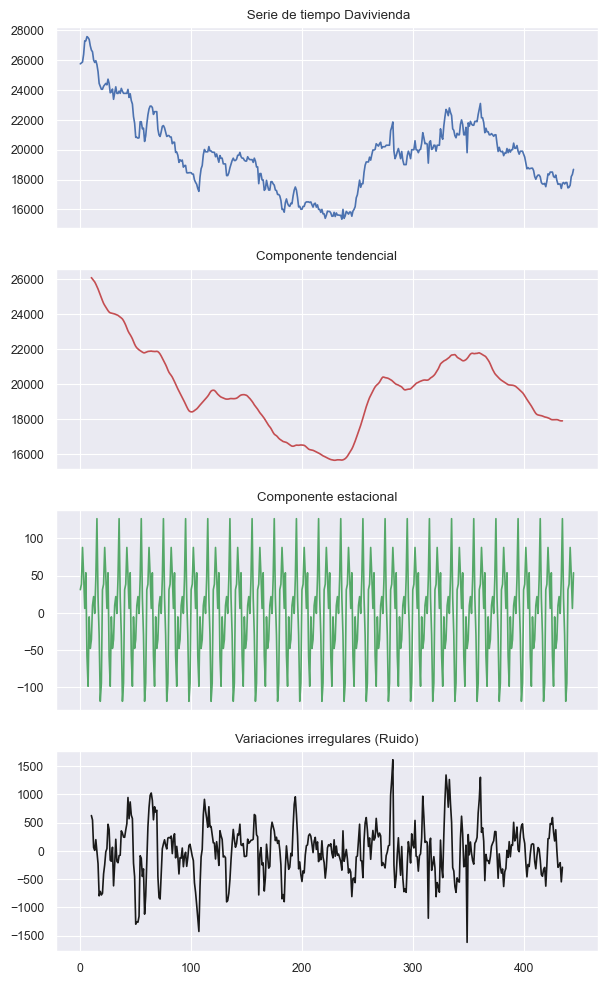

In [15]:
fig, axarr = plt.subplots(4, sharex=True)
fig.set_size_inches(7, 12)
sns.set_theme()
sns.set_context("paper")

data['adjclose'].plot(ax = axarr[0], color = 'b', linestyle = '-')
axarr[0].set_title(' Serie de tiempo Davivienda')

pd.Series(data = decompose_model.trend, index = data.index).plot(color = 'r', linestyle='-', ax=axarr[1])
axarr[1].set_title('Componente tendencial')

pd.Series(data = decompose_model.seasonal, index = data.index).plot(color = 'g', linestyle = '-', ax=axarr[2])
axarr[2].set_title('Componente estacional')

pd.Series(data = decompose_model.resid, index = data.index).plot(color = 'k', linestyle = '-', ax=axarr[3])
axarr[3].set_title('Variaciones irregulares (Ruido)');


En el primer gráfico, el **componente tendencial** muestra una disminución general a lo largo del tiempo, con algunas variaciones menores. El segundo gráfico representa la **estacionalidad**, que exhibe un patrón repetitivo con una amplitud constante, lo que indica un comportamiento cíclico regular. Finalmente, el último gráfico muestra el **ruido**, compuesto por variaciones aleatorias sin un patrón definido, lo que sugiere que estos movimientos no pueden ser explicados ni por la tendencia ni por la estacionalidad.

Ahora ejecutamos la prueba ADF sobre los residuos del modelo aditivo.

In [16]:
adf_result = adfuller(decompose_model.resid[np.where(np.isfinite(decompose_model.resid))[0]], autolag = 'AIC')
print('p-valor:', adf_result[1])

p-valor: 1.8216363079502723e-10


Aplicando la prueba a los residuos del modelo aditivo obtenemos un p-valor de **5.07656783913623e-13**, que es mucho menor que el obtenido con la serie temporal original.

### **Prueba de normalidad.**
Ahora, veamos la normalidad del conjunto de datos residuales.

- **Hipótesis Nula (H₀):** La muestra parece provenir de una distribución normal.
- **Hipótesis Alternativa (H₁):** La muestra NO parece provenir de una distribución normal.

In [17]:
decompose_model = seasonal.seasonal_decompose(data["adjclose"].tolist(),period = 20, model = 'additive')
resid_clean = decompose_model.resid
resid_clean = np.where(np.isinf(resid_clean), np.nan, resid_clean)  # Reemplazar infinitos por NaN
resid_clean = resid_clean[~np.isnan(resid_clean)]  # Eliminar los NaN

# Reemplaza los valores infinitos por NA y luego elimina los NA
stat , p = shapiro(resid_clean)
print('Statistics = %.3f, p = %.3f' % (stat, p))

Statistics = 0.986, p = 0.000


Dado que el p-valor es un valor muy chiquito, menor que el valor de significancia (`0.05`) se rechaza la hipótesis nula y se afirma la alternativa, es decir la muestra de los residuos NO parece provenir de una distribución normal.

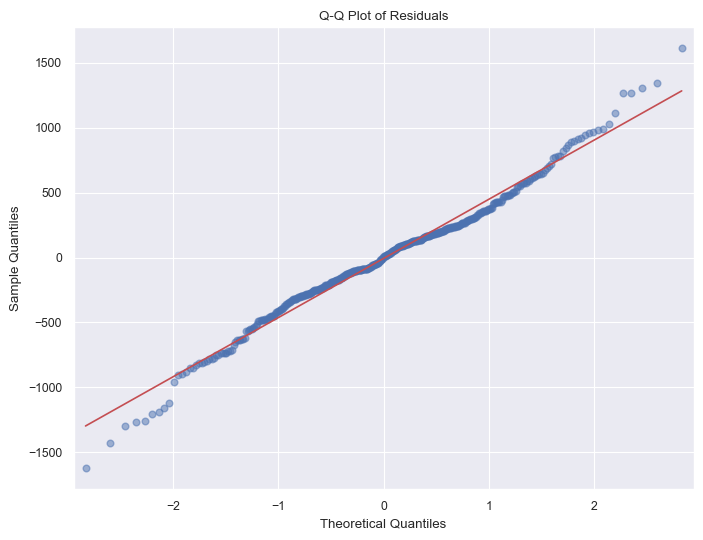

In [18]:
decompose_model = seasonal.seasonal_decompose(data['adjclose'], period=20, model='additive')
plt.rcParams.update({'figure.figsize': (8, 6)})
fig = sm.qqplot(decompose_model.resid.dropna(), line='s', alpha=0.5, color='b', lw=2)
plt.title('Q-Q Plot of Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.grid(True)
plt.show()

La gráfica muestra un indicio de normalidad significativa en el conjunto de datos residuales de Davivienda. Sin embargo, notamos que algunos residuos presentan una tendencia NO normal respecto al resto de datos de la muestra, lo cual confirma lo anteriormente dicho en la prueba de normalidad.

# **Modelo ARIMA**

El objetivo del análisis de series temporales es construir un modelo matemático capaz de capturar y explicar los patrones observados en una serie temporal, permitiendo no solo comprender su comportamiento histórico, sino también predecir con precisión su evolución futura.

## **Diferenciación**

Dado que ya observamos que la serie de tiempo correspondiente a los datos del Banco Davivienda no son estacionarios, entonces, usaremos la diferenciación para estacionarlos y posteriormente usar el Modelo `ARIMA` (Autorregresivo integrado de media móvil).

La diferenciación busca convertir una serie temporal no estacionaria en estacionaria, eliminando tendencias y preparando los datos para análisis y predicciones más precisas mediante modelos adecuados.

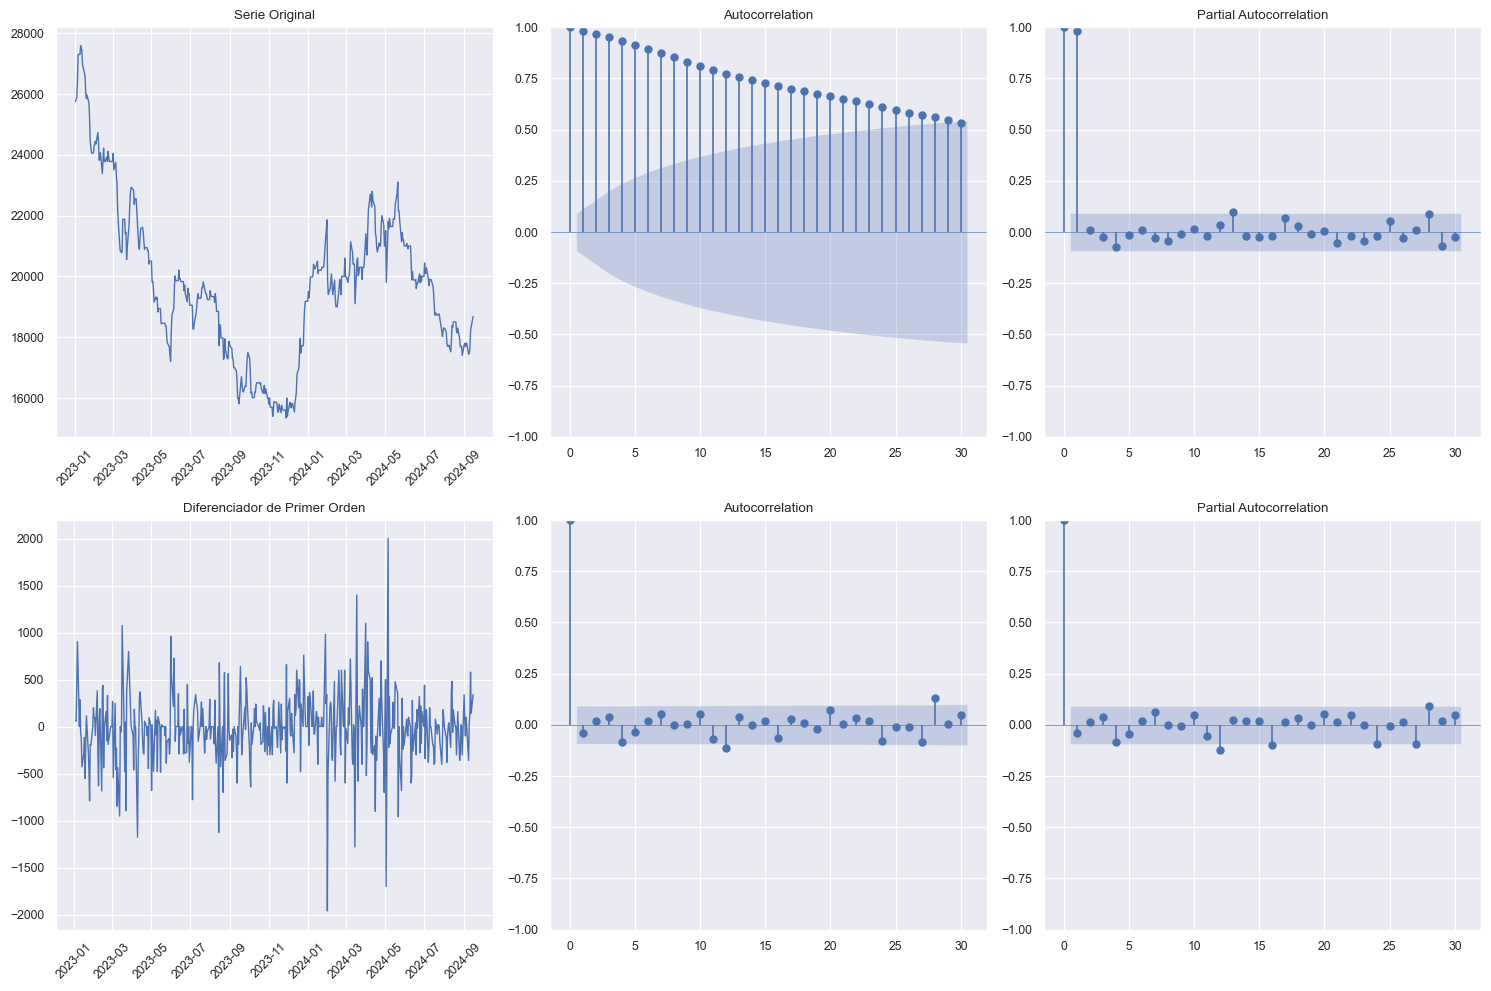

In [19]:
plt.rcParams.update({'text.usetex'     : False})
plt.rcParams.update({'figure.figsize'  : (15, 10)})

nlag = 30
fig, axes = plt.subplots(2, 3, sharex = False)

# Serie Original
axes[0, 0].plot(data['date'], data['adjclose'], linewidth = 1)
axes[0, 0].set_title('Serie Original')
plot_acf(data["adjclose"], lags = nlag, linewidth = 0.5, ax = axes[0, 1])
plot_pacf(data["adjclose"], lags = nlag, linewidth = 0.5, ax = axes[0, 2])

# Diferenciador de Primer Orden
axes[1, 0].plot(data["date"], data['adjclose'].diff(), linewidth = 1)
axes[1, 0].set_title('Diferenciador de Primer Orden')
plot_acf(data["adjclose"].diff().dropna(), lags = nlag, linewidth = 0.5, ax = axes[1, 1])
plot_pacf(data["adjclose"].diff().dropna(), lags = nlag, linewidth = 0.5, ax = axes[1, 2])

# Rotar los valores del eje x solo para las gráficas de las series temporales
for ax in [axes[0, 0], axes[1, 0]]:
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)

plt.tight_layout()
plt.show()


Después de aplicar el diferenciador de primer orden, la serie se vuelve más estacionaria, eliminando la tendencia a largo plazo. Esto se confirma en los gráficos ACF y PACF de la serie diferenciada, donde las correlaciones son más débiles, lo que indica que el proceso de diferenciación ha sido efectivo para eliminar la tendencia original y facilitar un análisis más claro de los cambios en los valores recientes.

Comprobemos la estacionaridad de la primera diferenciación con la prueba de `Dickey-Fuller`

In [20]:
adjclose_diff = data["adjclose"].diff().dropna()
adf_result2 = adfuller(adjclose_diff)
print('ADF Statistic: %f' % adf_result2[0])
print('p-value: %f' % adf_result2[1])

ADF Statistic: -21.871626
p-value: 0.000000


Dado el p-valor bajo que presenta la prueba luego de haber realizado la diferenciación de primer orden a los datos es posible afirmar que la serie es **Estacionaria** y ahora está lista para aplicar el modelo ARIMA

## **Criterios AIC, BIC y HQIC**
Los criterios de información de Akaike (AIC), Bayesiano (BIC) y de Hannan-Quinn (HQIC) utilizan el método de estimación de máxima verosimilitud (log-verosimilitud) de los modelos como medida de ajuste. Estas medidas buscan valores bajos para indicar un mejor ajuste del modelo a los datos.

Se realiza la división de los datos para el entrenamiento y test del modelo.

In [21]:
n_data = len(data.adjclose)
n_test = 30
train_size = n_data - n_test

In [22]:
train = data.adjclose[:train_size]
dates_train = data.date[:train_size]

test = data.adjclose[train_size:train_size + n_test]
dates_test = data.date[train_size:train_size + n_test]

print("Train:", train.shape)
print("Test:", test.shape)

Train: (416,)
Test: (30,)


In [23]:
# tolist se usa para convertir a listas estándar de python
train_list = train.tolist()

test7 = data.adjclose[train_size:train_size + 7]
dates_test7 = data.date[train_size:train_size + 7]
test7 = test7.tolist()


test14 = data.adjclose[train_size:train_size + 14]
dates_test14 = data.date[train_size:train_size + 14]
test14 = test14.tolist()


test21 = data.adjclose[train_size:train_size + 21]
dates_test21 = data.date[train_size:train_size + 21]
test21 = test21.tolist()


test28 = data.adjclose[train_size:train_size + 28]
dates_test28 = data.date[train_size:train_size + 28]
test28 = test28.tolist()

Ahora, se ajustará el modelo ARIMA para explorar diferentes combinaciones de órdenes `p,d,q`. Se utilizará el método de máxima verosimilitud `method = 'mle'` para el cálculo de la verosimilitud exacta a través del filtro de Kalman.

- `p`: Corresponde al orden de la parte autoregresiva del modelo (AR). Representan el número de observaciones pasadas (lags) que se utilizan para predecir el valor actual de la serie.
- `d`: Corresponde al número de diferenciaciones que se le realizan a la serie de tiempo para hacerla estacionaria.
- `q`: Corresponde al orden de la parte de media móvil del modelo (MA) y representa cuántos errores pasados están influyendo en el valor presente de la serie.

In [24]:
train_df = data[["adjclose"]][:train_size]
test_df = data[["adjclose"]][train_size:train_size + n_test]

En esta parte se encuentra el mejor modelo y las mejores combinaciones de órdenes para cada uno de los tres tipos de criterios (AIC, BIC y HQIC) evaluando en el conjunto de entrenamiento.

In [25]:
def best_model(train):
    # Inicializar los mejores valores
    best_aic = np.inf  # Mejor AIC
    best_bic = np.inf  # Mejor BIC
    best_hqic = np.inf  # Mejor HQIC

    best_order_aic = None  # Mejor orden para AIC
    best_order_bic = None  # Mejor orden para BIC
    best_order_hqic = None  # Mejor orden para HQIC

    best_mdl_aic = None  # Mejor modelo basado en AIC
    best_mdl_bic = None  # Mejor modelo basado en BIC
    best_mdl_hqic = None  # Mejor modelo basado en HQIC

    # Rango de p, d y q
    pq_rng = range(5)
    d_rng = range(3)

    # Iterar sobre todos los posibles valores de p, d, q
    for p in pq_rng:
        for d in d_rng:
            for q in pq_rng:
                try:
                    # Ajustar el modelo ARIMA
                    tmp_mdl = ARIMA(train, order=(p, d, q)).fit()

                    # Obtener los valores de AIC, BIC y HQIC
                    tmp_aic = tmp_mdl.aic
                    tmp_bic = tmp_mdl.bic
                    tmp_hqic = tmp_mdl.hqic

                    # Comparar el AIC
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order_aic = (p, d, q)
                        best_mdl_aic = tmp_mdl

                    # Comparar el BIC
                    if tmp_bic < best_bic:
                        best_bic = tmp_bic
                        best_order_bic = (p, d, q)
                        best_mdl_bic = tmp_mdl

                    # Comparar el HQIC
                    if tmp_hqic < best_hqic:
                        best_hqic = tmp_hqic
                        best_order_hqic = (p, d, q)
                        best_mdl_hqic = tmp_mdl

                except:
                    continue

    return {
        'AIC': {'best_aic': best_aic, 'best_order': best_order_aic, 'best_model': best_mdl_aic},
        'BIC': {'best_bic': best_bic, 'best_order': best_order_bic, 'best_model': best_mdl_bic},
        'HQIC': {'best_hqic': best_hqic, 'best_order': best_order_hqic, 'best_model': best_mdl_hqic}
    }

# Usar la función con tus datos de entrenamiento
results = best_model(train)

print("Mejor modelo basado en AIC:", results['AIC'])
print("Mejor modelo basado en BIC:", results['BIC'])
print("Mejor modelo basado en HQIC:", results['HQIC'])

Mejor modelo basado en AIC: {'best_aic': 6116.535875902349, 'best_order': (2, 1, 2), 'best_model': <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x000001B513489E80>}
Mejor modelo basado en BIC: {'best_bic': 6121.753612384275, 'best_order': (0, 1, 0), 'best_model': <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x000001B513996280>}
Mejor modelo basado en HQIC: {'best_hqic': 6119.318256832274, 'best_order': (0, 1, 0), 'best_model': <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x000001B513996280>}


En este caso no usaremos el `auto_arima` porque este se basa en solo el dato anterior para realizar predicciones, lo cual puede provocar un mal ajuste en el análisis que se desea realizar. Los precios de una acción en Davivienda son importantes por lo tanto se necesita considerar la evolución histórica para comprender mejor los comportamientos de los valores.

## **Modelo ARIMA con rolling forecast**

Ahora realizaremos pronósticos utilizando el método de **pronóstico continuo** o **rolling forecasting**, el cual aprovecha los datos históricos para generar predicciones continuas sobre un período. Este enfoque permite hacer ajustes en tiempo real, optimizar la planificación y mejorar la toma de decisiones. En nuestro caso, aplicaremos este método para prever horizontes de 7, 14, 21 y 28 días, para cada uno de los criterios.

In [26]:
def arima_rolling(history, test, best_order):

    predictions = []  # Lista donde se almacenarán las predicciones

    # Recorrer el conjunto de prueba
    for t in range(len(test)):
        # Crear y ajustar un modelo ARIMA con los datos históricos
        model = ARIMA(history, order = best_order)
        model_fit = model.fit()

        # Generar pronóstico para el siguiente valor (1 paso adelante)
        output = model_fit.forecast()
        yhat = output[0]  # El pronóstico es el primer valor del forecast

        predictions.append(yhat)  # Almacenar la predicción en la lista

        # Obtener el valor real observado en el conjunto de prueba
        obs = test[t]

        # Añadir la observación actual al conjunto de datos históricos
        history.append(obs)

        # Imprimir el valor pronosticado y el valor real
        print('predicho = %f, esperado = %f' % (yhat, obs))

    return predictions

Ahora se segmenta el conjunto de datos en intervalos de prueba con horizontes de 7, 14, 21 y 28 días, donde se extraen los valores ajustados de cierre y las fechas correspondientes para cada horizonte

## **Modelo ARIMA sin rolling forecast**

Para realizar el pronóstico sin el enfoque **rolling**, simplemente debemos eliminar la línea de código que actualiza el conjunto `history` con los valores observados del `test`. Esto implica que, en la nueva función, el conjunto de entrenamiento permanecerá estático y no se ajustará con cada nueva predicción.

In [27]:
def arima_sin_rolling(test, modelo):
    # Calcular el número de pasos de predicción basados en el tamaño del conjunto de prueba
    forecast_steps = len(test)
    
    # Realizar las predicciones para el número de pasos determinado
    forecast_tipo = modelo.forecast(steps=forecast_steps)
    
    # Convertir a un array para acceder por índice numérico
    forecast_values = forecast_tipo.values
    
    # Imprimir los valores observados y predichos
    for i in range(len(test)):
        observado = test[i]  # Valores observados
        predicho = forecast_values[i]  # Acceder a los valores predichos por índice
        print(f'Predicho: {predicho}, Observado: {observado}')

    # Devolver las predicciones
    return forecast_values

A continuación se ajustará el modelo para cada criterio y sus diferentes características para el modelo ARIMA

## **Tabla de error**

En esta parte se crea un método que permite calcular las tablas de error utilizando las métricas `MAPE, MAE, RMSE, MSE`

In [28]:
def forecast_accuracy(forecast, actual, str_name):

    mape = np.mean(np.abs(forecast - actual)/np.abs(actual)) # MAPE
    mae = np.mean(np.abs(forecast - actual))                 # MAE
    rmse = np.mean((forecast - actual)**2)**.5               # RMSE
    mse = np.mean((forecast - actual)**2)                    # MSE
    r2 = r2_score(forecast, actual)

    df_acc = pd.DataFrame({'MAE': [mae],
                           'MSE': [mse],
                           'MAPE': [mape],
                           'RMSE': [rmse],
                           'R2': [r2]},
                          index=[str_name])

    return df_acc

## **Criterio AIC**

### **Modelo ajustado**

Inicialmente, se ajustará el modelo teniendo en cuenta los mejores ordenes obtenidos anteriormente para el criterio de **Akaike**.

In [29]:
best_order_aic = results['AIC']['best_order']
model_aic = ARIMA(train, order = best_order_aic)
model_fit_aic = model_aic.fit()

La siguiente gráfica representa la predicción realizada utilizando el modelo ARIMA ajustado al conjunto de datos de entrenamiento y al mejor orden obtenido para el criterio AIC

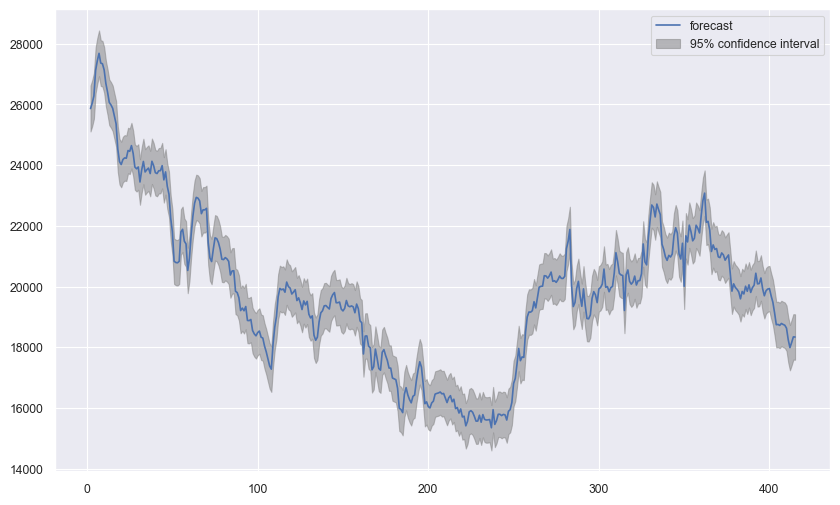

In [30]:
plt.rcParams.update({'figure.figsize': (10,6)})
plot_predict(model_fit_aic, 2);
# El valor 2 significa que la predicción comenzará desde la segunda observación.
plt.show();

Al ver la gráfica notamos que la cobertura que abarca el intervalo de confianza no es muy ancha. Lo que podría indicar una buena precisión en predecir los pronósticos.

### **Modelo ARIMA con rolling forecast**

Ahora, apliquemos el modelo ARIMA con rolling forecast teniendo en cuenta los conjuntos anteriormente seleccionados y el mejor orden obtenido por el criterio AIC

In [31]:
print('ARIMA Rolling AIC- Horizonte de 7 días.')
yhat7_aic = arima_rolling(train_list, test7, best_order_aic)

print('\nARIMA Rolling AIC - Horizonte de 14 días.')
yhat14_aic = arima_rolling(train_list, test14, best_order_aic)

print('\nARIMA Rolling AIC - Horizonte de 21 días.')
yhat21_aic = arima_rolling(train_list, test21, best_order_aic)

print('\nARIMA Rolling AIC - Horizonte de 28 días.')
yhat28_aic = arima_rolling(train_list, test28, best_order_aic)

ARIMA Rolling AIC- Horizonte de 7 días.
predicho = 18140.785452, esperado = 17800.000000
predicho = 17795.836544, esperado = 17700.000000
predicho = 17737.605384, esperado = 17700.000000
predicho = 17692.860425, esperado = 17740.000000
predicho = 17704.911249, esperado = 17520.000000
predicho = 17548.283932, esperado = 17900.000000
predicho = 17900.340217, esperado = 18380.000000

ARIMA Rolling AIC - Horizonte de 14 días.
predicho = 18334.989467, esperado = 17800.000000
predicho = 17852.094975, esperado = 17700.000000
predicho = 17722.523226, esperado = 17700.000000
predicho = 17645.177097, esperado = 17740.000000
predicho = 17729.790069, esperado = 17520.000000
predicho = 17585.406315, esperado = 17900.000000
predicho = 17867.564558, esperado = 18380.000000
predicho = 18309.346571, esperado = 18320.000000
predicho = 18377.774930, esperado = 18500.000000
predicho = 18541.652146, esperado = 18500.000000
predicho = 18439.719518, esperado = 18500.000000
predicho = 18475.582271, esperado =

Veamos gráficamente lo anterior.

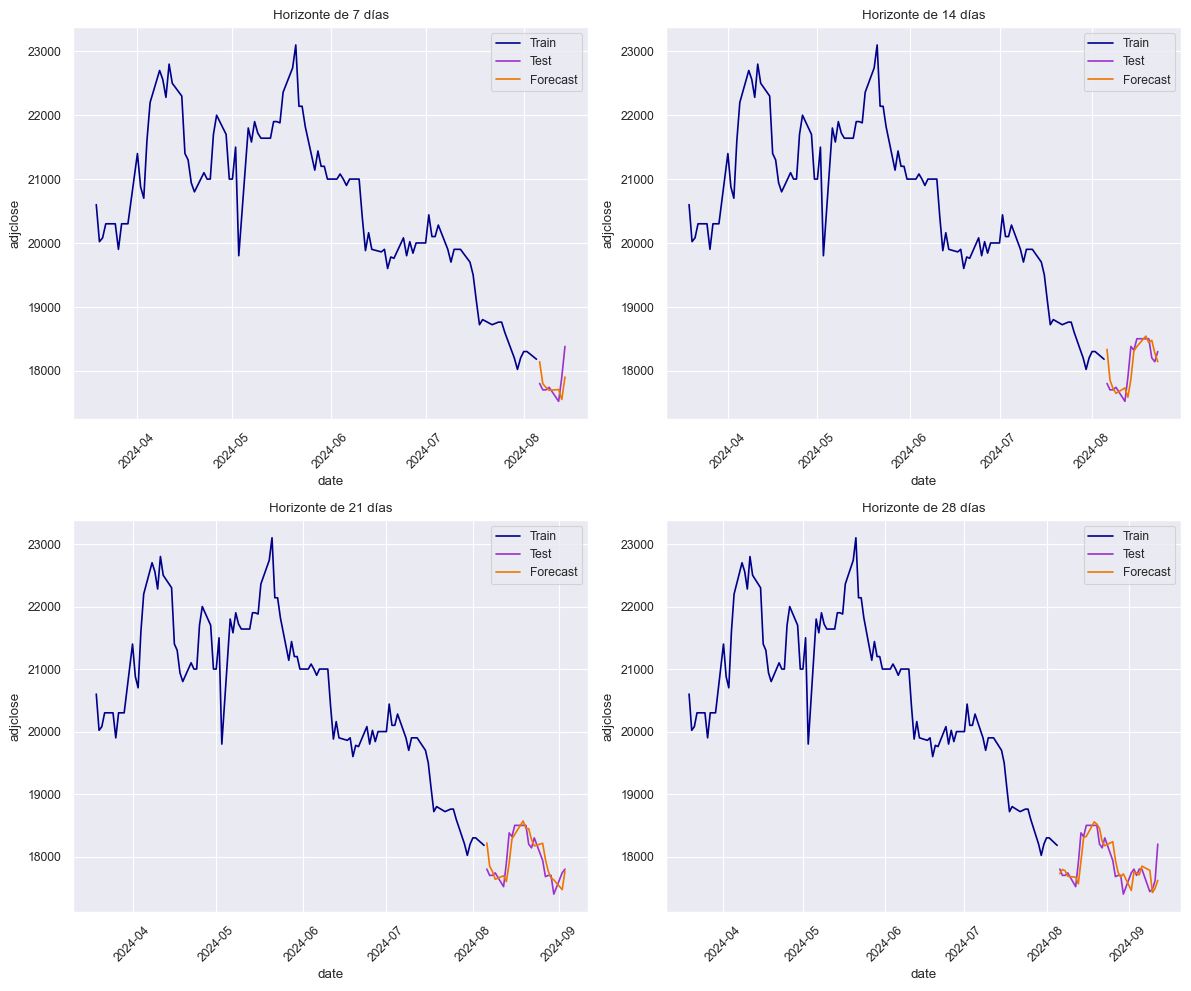

In [32]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
# -100: seleccionar los últimos 100 elementos.

# Horizonte de 7 días
sns.lineplot(ax = axs[0, 0], x = dates_train[-100:], y = train[-100:], label = 'Train', color = '#00008B')
sns.lineplot(ax = axs[0, 0], x = dates_test7, y = test7, label = 'Test', color = '#9A32CD')
sns.lineplot(ax = axs[0, 0], x = dates_test7, y = yhat7_aic, label = 'Forecast', color = '#EE7600')
axs[0, 0].set_title('Horizonte de 7 días')
axs[0, 0].tick_params(axis = 'x', rotation = 45)

# Horizonte de 14 días
sns.lineplot(ax = axs[0, 1], x = dates_train[-100:], y = train[-100:], label = 'Train', color = '#00008B')
sns.lineplot(ax = axs[0, 1], x = dates_test14, y = test14, label = 'Test', color = '#9A32CD')
sns.lineplot(ax = axs[0, 1], x = dates_test14, y = yhat14_aic, label = 'Forecast', color = '#EE7600')
axs[0, 1].set_title('Horizonte de 14 días')
axs[0, 1].tick_params(axis = 'x', rotation = 45)

# Horizonte de 21 días
sns.lineplot(ax = axs[1, 0], x = dates_train[-100:], y = train[-100:], label = 'Train', color = '#00008B')
sns.lineplot(ax = axs[1, 0], x = dates_test21, y = test21, label = 'Test', color = '#9A32CD')
sns.lineplot(ax = axs[1, 0], x = dates_test21, y = yhat21_aic, label = 'Forecast', color = '#EE7600')
axs[1, 0].set_title('Horizonte de 21 días')
axs[1, 0].tick_params(axis = 'x', rotation = 45)

# Horizonte de 28 días
sns.lineplot(ax = axs[1, 1], x = dates_train[-100:], y = train[-100:], label = 'Train', color = '#00008B')
sns.lineplot(ax = axs[1, 1], x = dates_test28, y = test28, label = 'Test', color = '#9A32CD')
sns.lineplot(ax = axs[1, 1], x = dates_test28, y = yhat28_aic, label = 'Forecast', color = '#EE7600')
axs[1, 1].set_title('Horizonte de 28 días')
axs[1, 1].tick_params(axis = 'x', rotation = 45)

plt.tight_layout()
plt.show()


En las gráficas se observan las predicciones del modelo ARIMA para diferentes horizontes de tiempo: 7, 14, 21 y 28 días. En todas ellas, la línea azul representa los datos de entrenamiento, la línea morada los datos de prueba, y la línea naranja muestra las predicciones del modelo. A medida que el horizonte de predicción se extiende, se puede ver cómo las predicciones siguen de cerca la tendencia de los datos reales, aunque la precisión disminuye ligeramente conforme aumenta el horizonte. Esto sugiere que el modelo ARIMA ha logrado ajustarse bien a los datos a corto plazo, pero puede perder algo de precisión al predecir en plazos más largos.

### **Modelo ARIMA sin rolling forecast**

Veamos ahora el modelo ARIMA sin rolling forecast teniendo en cuenta los conjuntos anteriormente seleccionados y el mejor orden obtenido por el criterio AIC


In [33]:
print('ARIMA sin Rolling AIC - Horizonte de 7 días.')
yhat7_sin_aic = arima_sin_rolling(test7, model_fit_aic)

print('\nARIMA sin Rolling AIC - Horizonte de 14 días.')
yhat14_sin_aic = arima_sin_rolling(test14, model_fit_aic)

print('\nARIMA sin Rolling AIC - Horizonte de 21 días.')
yhat21_sin_aic = arima_sin_rolling(test21, model_fit_aic)

print('\nARIMA sin Rolling AIC - Horizonte de 28 días')
yhat28_sin_aic = arima_sin_rolling(test28, model_fit_aic)

ARIMA sin Rolling AIC - Horizonte de 7 días.
Predicho: 18140.785452260676, Observado: 17800.0
Predicho: 18117.522143842278, Observado: 17700.0
Predicho: 18159.96247652562, Observado: 17700.0
Predicho: 18168.04664144553, Observado: 17740.0
Predicho: 18127.310026760493, Observado: 17520.0
Predicho: 18132.39911234162, Observado: 17900.0
Predicho: 18167.595406207078, Observado: 18380.0

ARIMA sin Rolling AIC - Horizonte de 14 días.
Predicho: 18140.785452260676, Observado: 17800.0
Predicho: 18117.522143842278, Observado: 17700.0
Predicho: 18159.96247652562, Observado: 17700.0
Predicho: 18168.04664144553, Observado: 17740.0
Predicho: 18127.310026760493, Observado: 17520.0
Predicho: 18132.39911234162, Observado: 17900.0
Predicho: 18167.595406207078, Observado: 18380.0
Predicho: 18152.308338391696, Observado: 18320.0
Predicho: 18125.208597688772, Observado: 18500.0
Predicho: 18147.233169061987, Observado: 18500.0
Predicho: 18164.982438430558, Observado: 18500.0
Predicho: 18139.722683994663, Ob

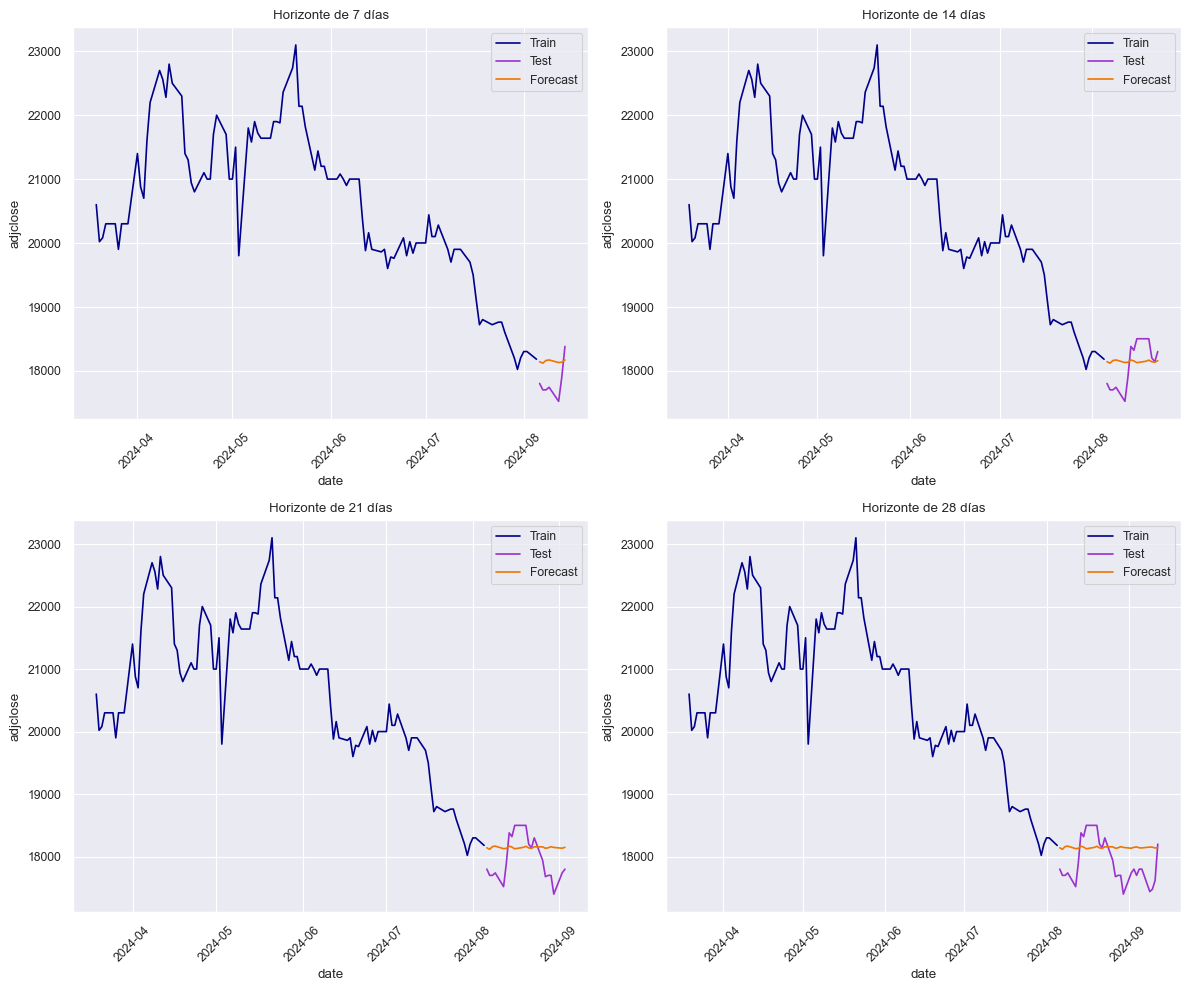

In [34]:
fig , axs = plt.subplots(2 , 2 , figsize = (12 , 10))

# Horizonte de 7 días
sns.lineplot(ax = axs[0 , 0] , x = dates_train[-100:] , y = train[-100:] , label = "Train" , color = '#00008B')
sns.lineplot(ax = axs[0 , 0] , x = dates_test7 , y = test7 , label = "Test" , color = '#9A32CD')
sns.lineplot(ax = axs[0 , 0] , x = dates_test7 , y = yhat7_sin_aic , label = "Forecast" , color = '#EE7600')
axs[0 , 0].set_title("Horizonte de 7 días")
axs[0 , 0].tick_params(axis = 'x' , rotation = 45)

# Horizonte de 14 días
sns.lineplot(ax = axs[0 , 1] , x = dates_train[-100:] , y = train[-100:] , label = "Train" , color = '#00008B')
sns.lineplot(ax = axs[0 , 1] , x = dates_test14 , y = test14 , label = "Test" , color = '#9A32CD')
sns.lineplot(ax = axs[0 , 1] , x = dates_test14 , y = yhat14_sin_aic , label = "Forecast" , color = '#EE7600')
axs[0 , 1].set_title("Horizonte de 14 días")
axs[0 , 1].tick_params(axis = 'x' , rotation = 45)

# Horizonte de 21 días
sns.lineplot(ax = axs[1 , 0] , x = dates_train[-100:] , y = train[-100:] , label = "Train" , color = '#00008B')
sns.lineplot(ax = axs[1 , 0] , x = dates_test21 , y = test21 , label = "Test" , color = '#9A32CD')
sns.lineplot(ax = axs[1 , 0] , x = dates_test21 , y = yhat21_sin_aic , label = "Forecast" , color = '#EE7600')
axs[1 , 0].set_title("Horizonte de 21 días")
axs[1 , 0].tick_params(axis = 'x' , rotation = 45)

# Horizonte de 28 días
sns.lineplot(ax = axs[1 , 1] , x = dates_train[-100:] , y = train[-100:] , label = "Train" , color = '#00008B')
sns.lineplot(ax = axs[1 , 1] , x = dates_test28 , y = test28 , label = "Test" , color = '#9A32CD')
sns.lineplot(ax = axs[1 , 1] , x = dates_test28 , y = yhat28_sin_aic , label = "Forecast" , color = '#EE7600')
axs[1 , 1].set_title("Horizonte de 28 días")
axs[1 , 1].tick_params(axis = 'x' , rotation = 45)

plt.tight_layout()
plt.show()

### **Análisis de residuos modelo ARIMA basado en el criterio AIC**

#### **Normalidad de los residuos**

Ahora, veamos la normalidad del conjunto de datos residuales por medio de la prueba de `Shapiro-Wilk` y luego veamos gráficamente la distribución.

- **Hipótesis Nula (H₀):** La muestra parece provenir de una distribución normal.
- **Hipótesis Alternativa (H₁):** La muestra NO parece provenir de una distribución normal.

Statistic = 0.181
P-Value = 6.185593628863644e-39
Se rechaza la hipótesis nula, por lo tanto los residuales no siguen una distribución normal.


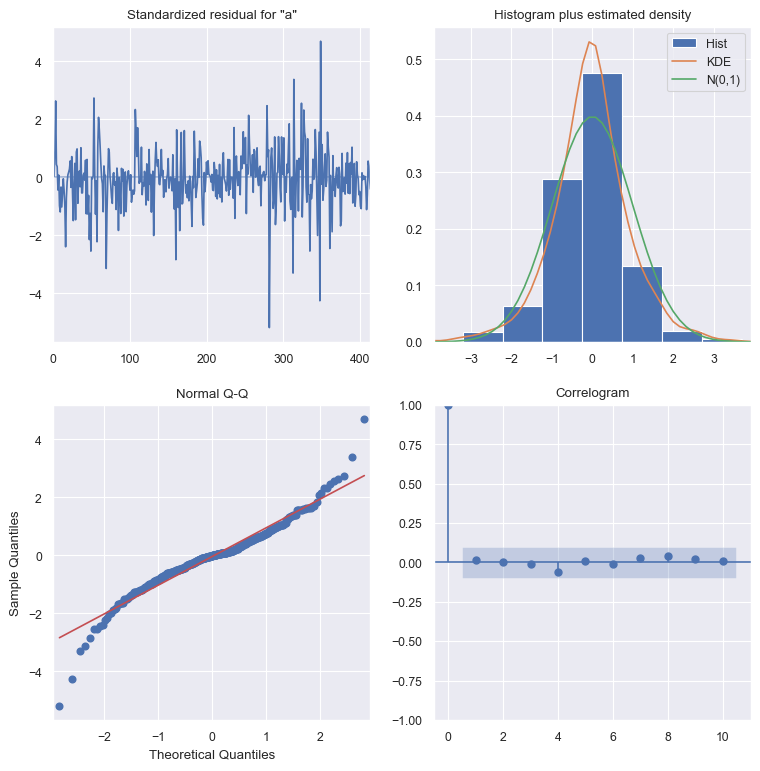

In [35]:
qq = model_fit_aic.plot_diagnostics(figsize=(9,9))

stat, pvalue = shapiro(model_fit_aic.resid)
print(f'Statistic = {stat:.3f}')
print(f'P-Value = {pvalue}')
if(pvalue < 0.05):
    print('Se rechaza la hipótesis nula, por lo tanto los residuales no siguen una distribución normal.')
else:
    print('No se rechaza la hipótesis nula, por lo tanto los residuales siguen una distribución normal.')

#### **Independencia de los residuos**

Uno de los principales supuestos de los modelos es que NO existe autocorrelación entre los residuos. Se usará la prueba de `Durbin-Watson`, teniendo en cuenta las siguientes hipótesis.


- **Hipótesis Nula (H₀):** No existe correlación entre los residuos
- **Hipótesis Alternativa (H₁):** Los residuos están correlacionados

Usaremos el estadístico de prueba para determinar si hay o no autocorrelación entre los residuos, dado que la prueba en sí no da un p-valor en su cálculo

Si:
- d = 2, NO hay autocorrelación
- d < 2, correlación positiva
- d > 2, correlación negativa.

In [36]:
dw = durbin_watson(model_fit_aic.resid)

print(f'Statistic d = {dw:.3f}')
if(dw < 1.5 or dw > 2.5):
    print('Se rechaza la hipótesis nula, los residuales están correlacionados.')
else:
    print('No se rechaza la hipótesis nula, no existe correlación entre los residuales.')

Statistic d = 1.061
Se rechaza la hipótesis nula, los residuales están correlacionados.


Luego de haber analizado los supuestos en los residuos de este modelo teniendo en cuenta el criterio AIC , se puede afirmar que los residuos no siguen una distribución normal y son dependientes entre sí, es decir, están correlacionados.

### **Comparación de modelos - Criterio AIC**

#### **Tablas de error**

Veamos las tablas de error tanto para el modelo ARIMA con y sin rolling forecast teniendo en cuenta el criterio AIC

In [37]:
accuracy7_aic =  forecast_accuracy(np.array(test7), np.array(yhat7_aic), "7 días")
accuracy14_aic = forecast_accuracy(np.array(test14), np.array(yhat14_aic), "14 días")
accuracy21_aic = forecast_accuracy(np.array(test21), np.array(yhat21_aic), "21 días")
accuracy28_aic = forecast_accuracy(np.array(test28), np.array(yhat28_aic), "28 días")

accuracy_rolling = pd.concat([accuracy7_aic, accuracy14_aic, accuracy21_aic, accuracy28_aic])

In [38]:
accuracy7_not_aic = forecast_accuracy(np.array(test7), np.array(yhat7_sin_aic), "7 días")
accuracy14_not_aic = forecast_accuracy(np.array(test14), np.array(yhat14_sin_aic), "14 días")
accuracy21_not_aic = forecast_accuracy(np.array(test21), np.array(yhat21_sin_aic), "21 días")
accuracy28_not_aic = forecast_accuracy(np.array(test28), np.array(yhat28_sin_aic), "28 días")

accuracy_not_rolling = pd.concat([ accuracy7_not_aic, accuracy14_not_aic, accuracy21_not_aic, accuracy28_not_aic])

In [39]:
accuracy_rolling

,MAE,MSE,MAPE,RMSE,R2
7 días,219.664865,73846.506079,0.012320,271.747136,-0.160066
14 días,189.093743,61763.898455,0.010475,248.523436,0.449780
21 días,175.476340,46224.025710,0.009771,214.997734,0.594594
28 días,162.768619,47190.801636,0.009121,217.234439,0.571882


De la tabla de error calculada al modelo ARIMA usando el rolling forecast y teniendo en cuenta el criterio AIC se puede decir que el MAE y RMSE son similares en los cuatro horizontes, lo que sugiere que el error medio no varía mucho al aumentar el periodo de predicción. Sin embargo, el valor de $R^2$ mejora con horizontes más largos, lo que indica que el modelo es más capaz de explicar la varianza de los datos en predicciones de 14, 21 y 28 días en comparación con las de 7 días, donde  $R^2$  es negativo, lo que sugiere un ajuste malo para ese horizonte en particular.

In [40]:
accuracy_not_rolling

,MAE,MSE,MAPE,RMSE,R2
7 días,385.490064,164742.771374,0.021247,405.885170,-1.587970
14 días,295.777042,113050.734856,0.016301,336.230181,-0.007106
21 días,342.942462,146494.093840,0.018900,382.745469,-0.284821
28 días,367.702051,169508.340336,0.020264,411.713906,-0.537790


#### **Gráficos de correlación**

En esta parte, se puede observar los gráficos de correlación entre la observación real y su predicción en el test para cada uno de los horizontes, teniendo en cuenta el criterio AIC y el uso de rolling forecasting.

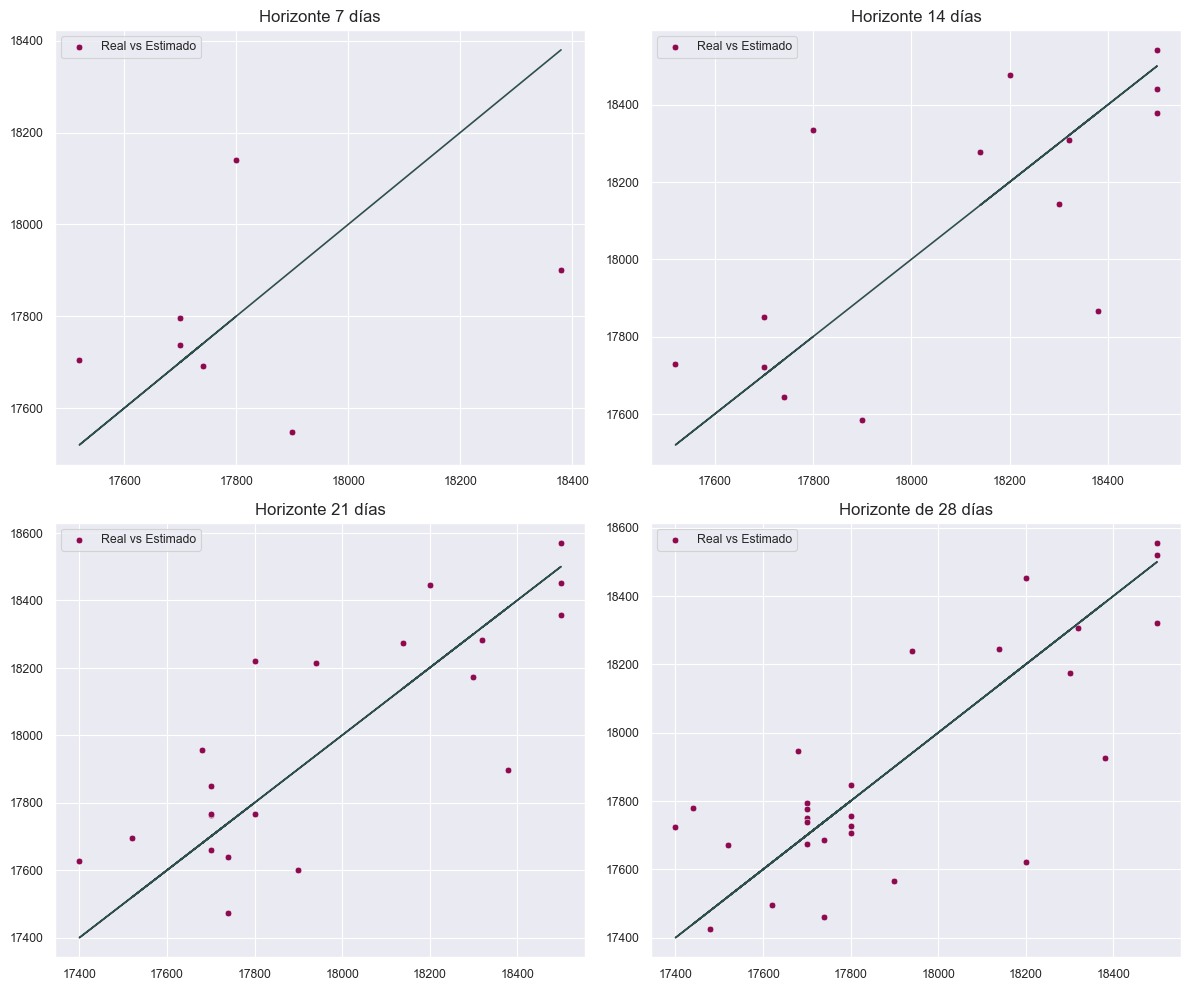

In [41]:
plt.rcParams.update({'figure.figsize' : (12 , 10)})
fig , axes = plt.subplots(nrows = 2 , ncols = 2)

# Horizonte de 7 días
sns.scatterplot(x = test7 , y = yhat7_aic , ax = axes[0 , 0] , color = '#8B0A50' , label = 'Real vs Estimado')
axes[0 , 0].plot(test7 , test7 , color = '#2F4F4F' , label = 'Correlación')
axes[0 , 0].set_title('Horizonte 7 días' , fontsize = 12)

# Horizonte de 14 días
sns.scatterplot(x = test14 , y = yhat14_aic , ax = axes[0 , 1] , color = '#8B0A50' , label = 'Real vs Estimado')
axes[0 , 1].plot(test14 , test14 , color = '#2F4F4F' , label = 'Correlación')
axes[0 , 1].set_title('Horizonte 14 días' , fontsize = 12)

# Horizonte de 21 días
sns.scatterplot(x = test21 , y = yhat21_aic , ax = axes[1 , 0] , color = '#8B0A50' , label = 'Real vs Estimado')
axes[1 , 0].plot(test21 , test21 , color = '#2F4F4F' , label = 'Correlación')
axes[1 , 0].set_title('Horizonte 21 días' , fontsize = 12)

# Horizonte de 28 días
sns.scatterplot(x = test28 , y = yhat28_aic , ax = axes[1 , 1] , color = '#8B0A50' , label = 'Real vs Estimado')
axes[1 , 1].plot(test28 , test28 , color = '#2F4F4F' , label = 'Correlación')
axes[1 , 1].set_title('Horizonte de 28 días' , fontsize = 12)

plt.tight_layout()
plt.show()



De la gráfica se puede observar que en el horizonte de 14 días, los puntos tienden a alinearse mejor con la diagonal, lo que indica una mejor precisión en las predicciones. Sin embargo, en los horizontes de 7, 21 y 28 días, los puntos se alejan más de la línea, lo que sugiere una menor exactitud en las predicciones, especialmente en los extremos. Esto refleja que el modelo ARIMA ajusta mejor en plazos más largos, pero puede tener dificultades para capturar los valores exactos en ciertos periodos.

### **Conclusiones criterio AIC**

En resumen, al evaluar el modelo ARIMA utilizando el criterio AIC y analizando los residuos obtenidos, se puede concluir que, aunque el modelo logra ajustarse adecuadamente a los datos de entrenamiento, los resultados de los diagnósticos indican ciertas limitaciones. La prueba de normalidad de Shapiro-Wilk demuestra que los residuos no siguen una distribución normal, lo que puede afectar la calidad de las predicciones. Adicionalmente, el estadístico de Durbin-Watson sugiere que los residuos están correlacionados, lo que podría indicar la presencia de autocorrelación en el modelo. A pesar de estos resultados, los gráficos de los diferentes horizontes de predicción (7, 14, 21 y 28 días) muestran que el modelo sigue una tendencia adecuada al predecir, aunque con variabilidad en los errores y coeficientes de correlación. Esto implica que, aunque el modelo es útil para ciertos fines de predicción, tiene limitaciones en cuanto a la independencia y distribución de los residuos, lo que podría ser mejorado ajustando algunos parámetros o probando otros modelos.

## **Criterio BIC**

### **Modelo ajustado**

Inicialmente, se ajustará el modelo teniendo en cuenta los mejores ordenes obtenidos anteriormente para el criterio de información **bayesiano**

In [42]:
best_order_bic = results['BIC']['best_order']
model_bic = ARIMA(train, order = best_order_bic)
model_fit_bic = model_bic.fit()

La siguiente gráfica representa la predicción realizada utilizando el modelo ARIMA ajustado al conjunto de datos de entrenamiento y al mejor orden obtenido para el criterio BIC

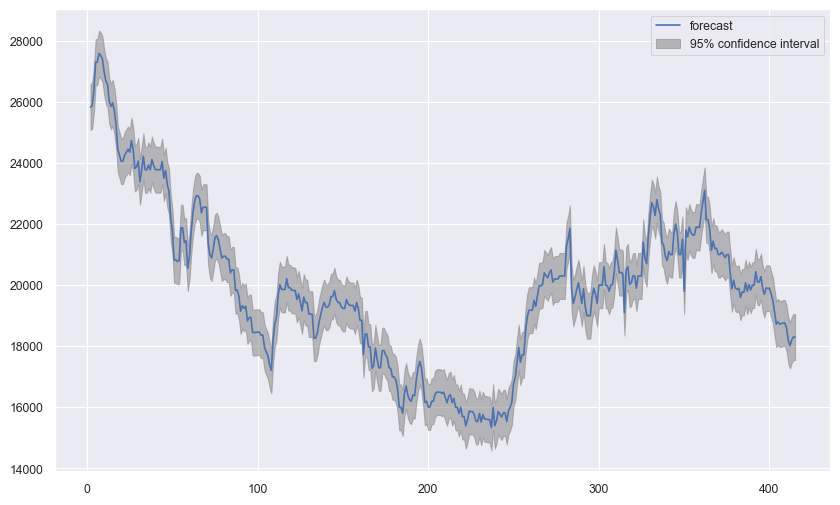

In [43]:
plt.rcParams.update({'figure.figsize': (10,6)})
plot_predict(model_fit_bic, 2);
# El valor 2 significa que la predicción comenzará desde la segunda observación.
plt.show();

Al ver la gráfica notamos que la cobertura que abarca el intervalo de confianza no es muy ancha. Lo que podría indicar una buena precisión en predecir los pronósticos.

### **Modelo ARIMA con rolling forecast**

Ahora, apliquemos el modelo ARIMA con rolling forecast teniendo en cuenta los conjuntos anteriormente seleccionados y el mejor orden obtenido por el criterio BIC

In [44]:
print('ARIMA Rolling BIC- Horizonte de 7 días.')
yhat7_bic = arima_rolling(train_list, test7, best_order_bic)

print('\nARIMA Rolling BIC - Horizonte de 14 días.')
yhat14_bic = arima_rolling(train_list, test14, best_order_bic)

print('\nARIMA Rolling BIC - Horizonte de 21 días.')
yhat21_bic = arima_rolling(train_list, test21, best_order_bic)

print('\nARIMA Rolling BIC - Horizonte de 28 días.')
yhat28_bic = arima_rolling(train_list, test28, best_order_bic)

ARIMA Rolling BIC- Horizonte de 7 días.
predicho = 18200.000000, esperado = 17800.000000
predicho = 17800.000000, esperado = 17700.000000
predicho = 17700.000000, esperado = 17700.000000
predicho = 17700.000000, esperado = 17740.000000
predicho = 17740.000000, esperado = 17520.000000
predicho = 17520.000000, esperado = 17900.000000
predicho = 17900.000000, esperado = 18380.000000

ARIMA Rolling BIC - Horizonte de 14 días.
predicho = 18380.000000, esperado = 17800.000000
predicho = 17800.000000, esperado = 17700.000000
predicho = 17700.000000, esperado = 17700.000000
predicho = 17700.000000, esperado = 17740.000000
predicho = 17740.000000, esperado = 17520.000000
predicho = 17520.000000, esperado = 17900.000000
predicho = 17900.000000, esperado = 18380.000000
predicho = 18380.000000, esperado = 18320.000000
predicho = 18320.000000, esperado = 18500.000000
predicho = 18500.000000, esperado = 18500.000000
predicho = 18500.000000, esperado = 18500.000000
predicho = 18500.000000, esperado =

Veamos gráficamente lo anterior.

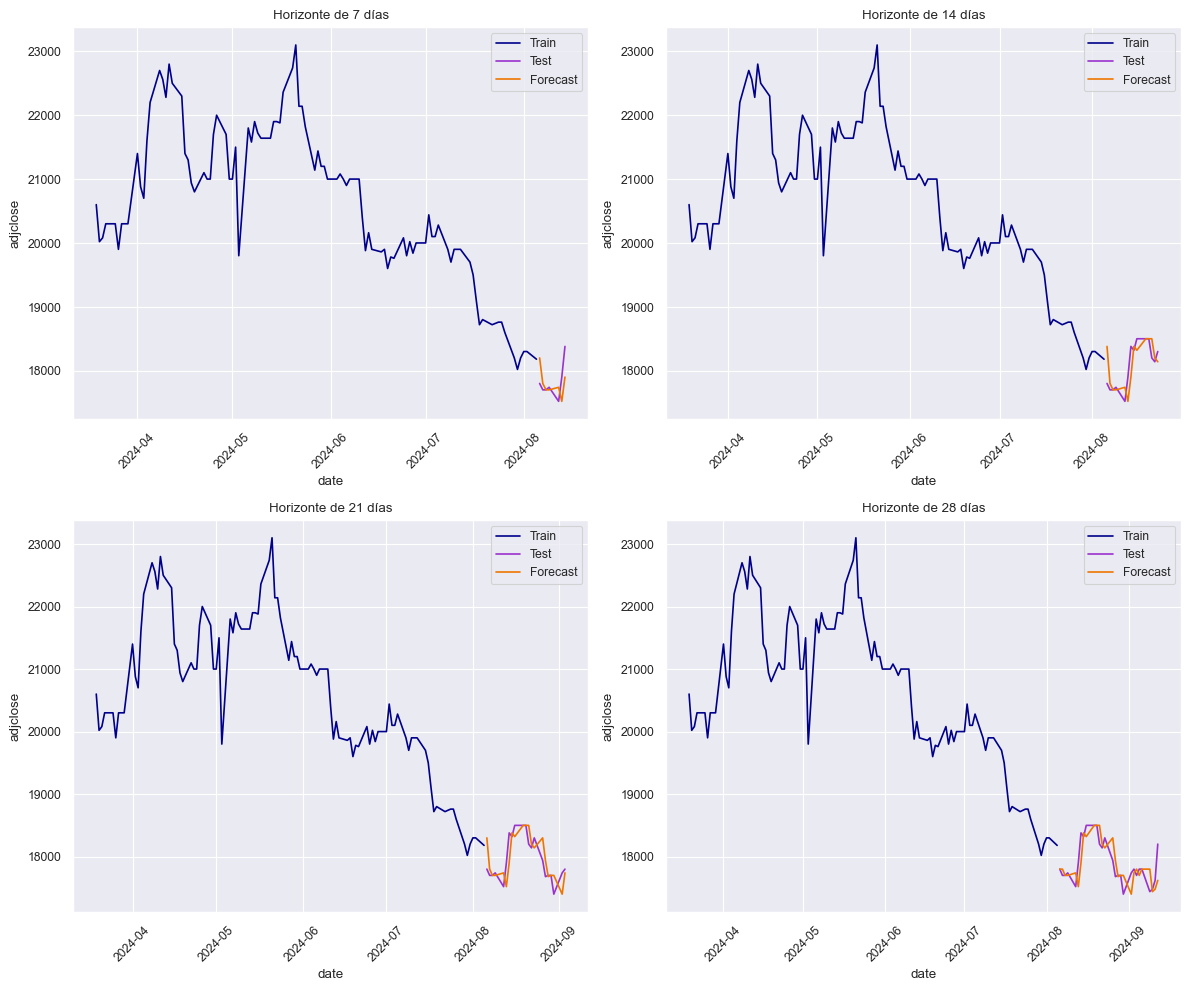

In [45]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
# -100: seleccionar los últimos 100 elementos.

# Horizonte de 7 días
sns.lineplot(ax = axs[0, 0], x = dates_train[-100:], y = train[-100:], label = 'Train', color = '#00008B')
sns.lineplot(ax = axs[0, 0], x = dates_test7, y = test7, label = 'Test', color = '#9A32CD')
sns.lineplot(ax = axs[0, 0], x = dates_test7, y = yhat7_bic, label = 'Forecast', color = '#EE7600')
axs[0, 0].set_title('Horizonte de 7 días')
axs[0, 0].tick_params(axis = 'x', rotation = 45)

# Horizonte de 14 días
sns.lineplot(ax = axs[0, 1], x = dates_train[-100:], y = train[-100:], label = 'Train', color = '#00008B')
sns.lineplot(ax = axs[0, 1], x = dates_test14, y = test14, label = 'Test', color = '#9A32CD')
sns.lineplot(ax = axs[0, 1], x = dates_test14, y = yhat14_bic, label = 'Forecast', color = '#EE7600')
axs[0, 1].set_title('Horizonte de 14 días')
axs[0, 1].tick_params(axis = 'x', rotation = 45)

# Horizonte de 21 días
sns.lineplot(ax = axs[1, 0], x = dates_train[-100:], y = train[-100:], label = 'Train', color = '#00008B')
sns.lineplot(ax = axs[1, 0], x = dates_test21, y = test21, label = 'Test', color = '#9A32CD')
sns.lineplot(ax = axs[1, 0], x = dates_test21, y = yhat21_bic, label = 'Forecast', color = '#EE7600')
axs[1, 0].set_title('Horizonte de 21 días')
axs[1, 0].tick_params(axis = 'x', rotation = 45)

# Horizonte de 28 días
sns.lineplot(ax = axs[1, 1], x = dates_train[-100:], y = train[-100:], label = 'Train', color = '#00008B')
sns.lineplot(ax = axs[1, 1], x = dates_test28, y = test28, label = 'Test', color = '#9A32CD')
sns.lineplot(ax = axs[1, 1], x = dates_test28, y = yhat28_bic, label = 'Forecast', color = '#EE7600')
axs[1, 1].set_title('Horizonte de 28 días')
axs[1, 1].tick_params(axis = 'x', rotation = 45)

plt.tight_layout()
plt.show()


### **Modelo ARIMA sin rolling forecast**

Veamos ahora el modelo ARIMA sin rolling forecast teniendo en cuenta los conjuntos anteriormente seleccionados y el mejor orden obtenido por el criterio BIC


In [70]:
print('ARIMA sin Rolling AIC - Horizonte de 7 días.')
yhat7_sin_bic = arima_sin_rolling(test7, model_fit_bic)

print('\nARIMA sin Rolling AIC - Horizonte de 14 días.')
yhat14_sin_bic = arima_sin_rolling(test14, model_fit_bic)

print('\nARIMA sin Rolling AIC - Horizonte de 21 días.')
yhat21_sin_bic = arima_sin_rolling(test21, model_fit_bic)

print('\nARIMA sin Rolling AIC - Horizonte de 28 días')
yhat28_sin_bic = arima_sin_rolling(test28, model_fit_bic)

ARIMA sin Rolling AIC - Horizonte de 7 días.
Predicho: 18180.0, Observado: 17800.0
Predicho: 18180.0, Observado: 17700.0
Predicho: 18180.0, Observado: 17700.0
Predicho: 18180.0, Observado: 17740.0
Predicho: 18180.0, Observado: 17520.0
Predicho: 18180.0, Observado: 17900.0
Predicho: 18180.0, Observado: 18380.0

ARIMA sin Rolling AIC - Horizonte de 14 días.
Predicho: 18180.0, Observado: 17800.0
Predicho: 18180.0, Observado: 17700.0
Predicho: 18180.0, Observado: 17700.0
Predicho: 18180.0, Observado: 17740.0
Predicho: 18180.0, Observado: 17520.0
Predicho: 18180.0, Observado: 17900.0
Predicho: 18180.0, Observado: 18380.0
Predicho: 18180.0, Observado: 18320.0
Predicho: 18180.0, Observado: 18500.0
Predicho: 18180.0, Observado: 18500.0
Predicho: 18180.0, Observado: 18500.0
Predicho: 18180.0, Observado: 18200.0
Predicho: 18180.0, Observado: 18140.0
Predicho: 18180.0, Observado: 18300.0

ARIMA sin Rolling AIC - Horizonte de 21 días.
Predicho: 18180.0, Observado: 17800.0
Predicho: 18180.0, Observ

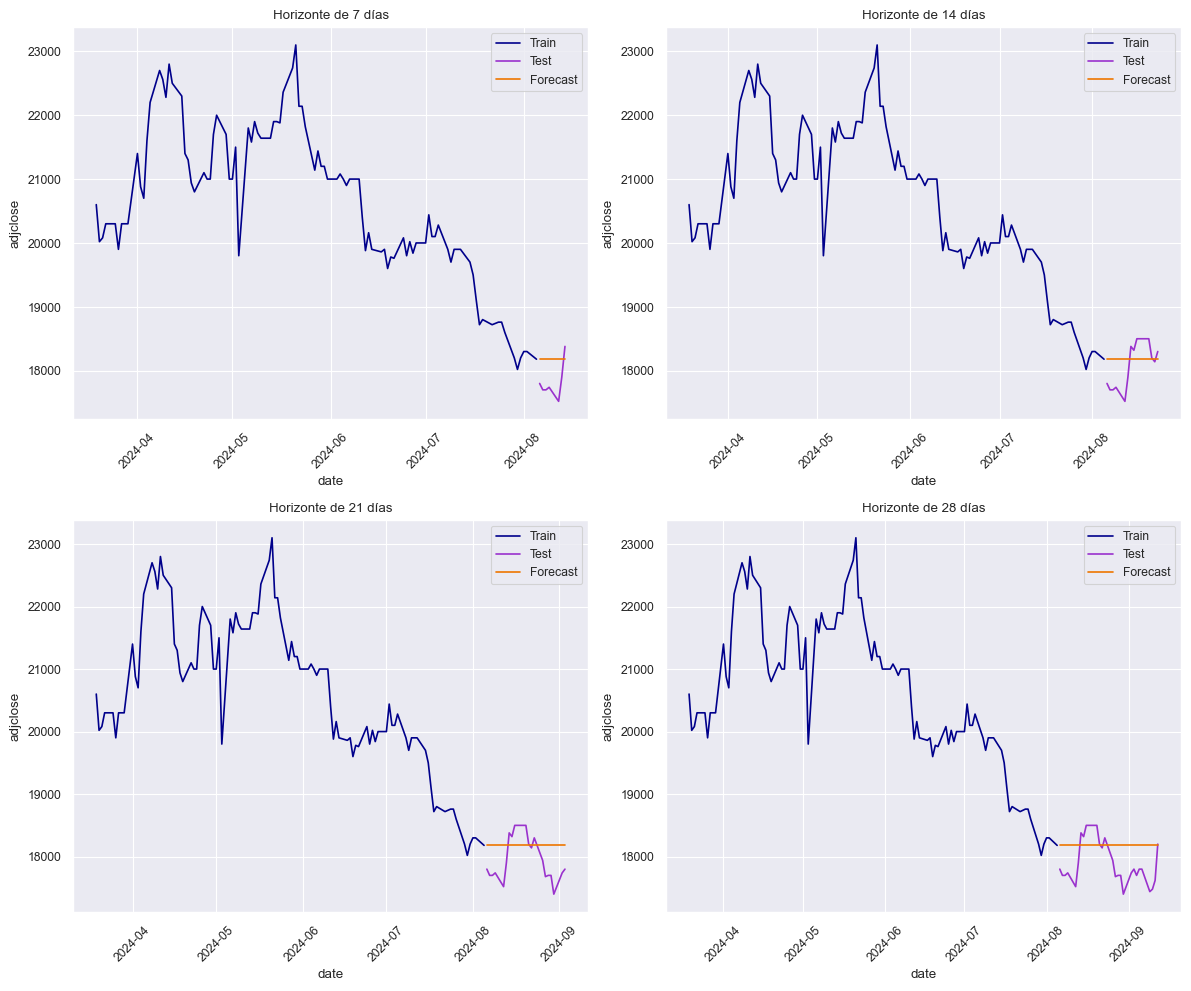

In [48]:
fig , axs = plt.subplots(2 , 2 , figsize = (12 , 10))

# Horizonte de 7 días
sns.lineplot(ax = axs[0 , 0] , x = dates_train[-100:] , y = train[-100:] , label = "Train" , color = '#00008B')
sns.lineplot(ax = axs[0 , 0] , x = dates_test7 , y = test7 , label = "Test" , color = '#9A32CD')
sns.lineplot(ax = axs[0 , 0] , x = dates_test7 , y = yhat7_sin_bic , label = "Forecast" , color = '#EE7600')
axs[0 , 0].set_title("Horizonte de 7 días")
axs[0 , 0].tick_params(axis = 'x' , rotation = 45)

# Horizonte de 14 días
sns.lineplot(ax = axs[0 , 1] , x = dates_train[-100:] , y = train[-100:] , label = "Train" , color = '#00008B')
sns.lineplot(ax = axs[0 , 1] , x = dates_test14 , y = test14 , label = "Test" , color = '#9A32CD')
sns.lineplot(ax = axs[0 , 1] , x = dates_test14 , y = yhat14_sin_bic , label = "Forecast" , color = '#EE7600')
axs[0 , 1].set_title("Horizonte de 14 días")
axs[0 , 1].tick_params(axis = 'x' , rotation = 45)

# Horizonte de 21 días
sns.lineplot(ax = axs[1 , 0] , x = dates_train[-100:] , y = train[-100:] , label = "Train" , color = '#00008B')
sns.lineplot(ax = axs[1 , 0] , x = dates_test21 , y = test21 , label = "Test" , color = '#9A32CD')
sns.lineplot(ax = axs[1 , 0] , x = dates_test21 , y = yhat21_sin_bic , label = "Forecast" , color = '#EE7600')
axs[1 , 0].set_title("Horizonte de 21 días")
axs[1 , 0].tick_params(axis = 'x' , rotation = 45)

# Horizonte de 28 días
sns.lineplot(ax = axs[1 , 1] , x = dates_train[-100:] , y = train[-100:] , label = "Train" , color = '#00008B')
sns.lineplot(ax = axs[1 , 1] , x = dates_test28 , y = test28 , label = "Test" , color = '#9A32CD')
sns.lineplot(ax = axs[1 , 1] , x = dates_test28 , y = yhat28_sin_bic , label = "Forecast" , color = '#EE7600')
axs[1 , 1].set_title("Horizonte de 28 días")
axs[1 , 1].tick_params(axis = 'x' , rotation = 45)

plt.tight_layout()
plt.show()


### **Análisis de residuos modelo ARIMA basado en el criterio BIC**

#### **Normalidad de los residuos**

Ahora, veamos la normalidad del conjunto de datos residuales por medio de la prueba de `Shapiro-Wilk` y luego veamos gráficamente la distribución.

- **Hipótesis Nula (H₀):** La muestra parece provenir de una distribución normal.
- **Hipótesis Alternativa (H₁):** La muestra NO parece provenir de una distribución normal.

Statistic = 0.182
P-Value = 6.36202053226988e-39
Se rechaza la hipótesis nula, por lo tanto los residuales no siguen una distribución normal.


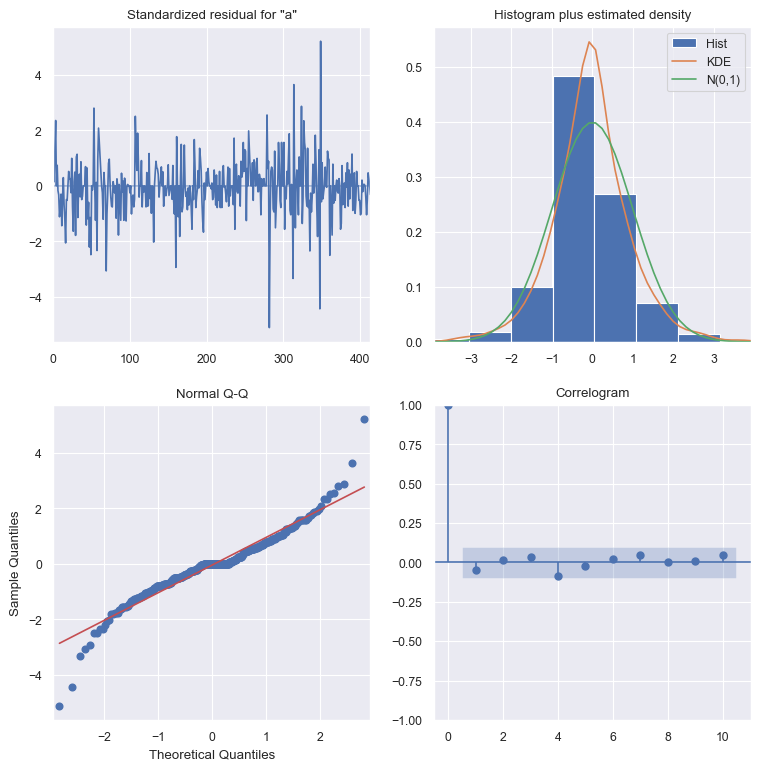

In [49]:
qq2 = model_fit_bic.plot_diagnostics(figsize=(9,9))

stat2, pvalue2 = shapiro(model_fit_bic.resid)
print(f'Statistic = {stat2:.3f}')
print(f'P-Value = {pvalue2}')
if(pvalue2 < 0.05):
    print('Se rechaza la hipótesis nula, por lo tanto los residuales no siguen una distribución normal.')
else:
    print('No se rechaza la hipótesis nula, por lo tanto los residuales siguen una distribución normal.')

#### **Independencia de los residuos**

Uno de los principales supuestos de los modelos es que NO existe autocorrelación entre los residuos. Se usará la prueba de `Durbin-Watson`, teniendo en cuenta las siguientes hipótesis.


- **Hipótesis Nula (H₀):** No existe correlación entre los residuos
- **Hipótesis Alternativa (H₁):** Los residuos están correlacionados

Usaremos el estadístico de prueba para determinar si hay o no autocorrelación entre los residuos, dado que la prueba en sí no da un p-valor en su cálculo

Si:
- d = 2, NO hay autocorrelación
- d < 2, correlación positiva
- d > 2, correlación negativa.

In [50]:
dw2 = durbin_watson(model_fit_bic.resid)

print(f'Statistic d = {dw2:.3f}')
if(dw2 < 1.5 or dw2 > 2.5):
    print('Se rechaza la hipótesis nula, los residuales están correlacionados.')
else:
    print('No se rechaza la hipótesis nula, no existe correlación entre los residuales.')

Statistic d = 1.087
Se rechaza la hipótesis nula, los residuales están correlacionados.


### **Comparación de modelos - Criterio BIC**




#### **Tablas de error**

Veamos las tablas de error tanto para el modelo ARIMA con y sin rolling forecast teniendo en cuenta el criterio BIC

In [51]:
accuracy7_bic =  forecast_accuracy(np.array(test7), np.array(yhat7_bic), "7 días")
accuracy14_bic = forecast_accuracy(np.array(test14), np.array(yhat14_bic), "14 días")
accuracy21_bic = forecast_accuracy(np.array(test21), np.array(yhat21_bic), "21 días")
accuracy28_bic = forecast_accuracy(np.array(test28), np.array(yhat28_bic), "28 días")

accuracy_rolling2 = pd.concat([accuracy7_bic, accuracy14_bic, accuracy21_bic, accuracy28_bic])

In [52]:
accuracy7_not_bic = forecast_accuracy(np.array(test7), np.array(yhat7_sin_bic), "7 días")
accuracy14_not_bic = forecast_accuracy(np.array(test14), np.array(yhat14_sin_bic), "14 días")
accuracy21_not_bic = forecast_accuracy(np.array(test21), np.array(yhat21_sin_bic), "21 días")
accuracy28_not_bic = forecast_accuracy(np.array(test28), np.array(yhat28_sin_bic), "28 días")

accuracy_not_rolling2 = pd.concat([ accuracy7_not_bic, accuracy14_not_bic, accuracy21_not_bic, accuracy28_not_bic])

In [53]:
accuracy_rolling2

,MAE,MSE,MAPE,RMSE,R2
7 días,231.428571,84971.428571,0.012966,291.498591,-0.334829
14 días,182.857143,66171.428571,0.010126,257.238078,0.410516
21 días,181.904762,59371.428571,0.010128,243.662530,0.479285
28 días,165.714286,53714.285714,0.009289,231.763426,0.512701


In [54]:
accuracy_not_rolling2

,MAE,MSE,MAPE,RMSE,R2
7 días,417.142857,193257.142857,0.022945,439.610217,-2.035907
14 días,300.000000,121142.857143,0.016502,348.055825,-0.079194
21 días,357.142857,162419.047619,0.019645,403.012466,-0.424490
28 días,384.285714,188628.571429,0.021138,434.313909,-0.711249


#### **Gráficos de correlación**

En esta parte, se puede observar los gráficos de correlación entre la observación real y su predicción en el test para cada uno de los horizontes, teniendo en cuenta el criterio BIC y el uso de rolling forecasting.


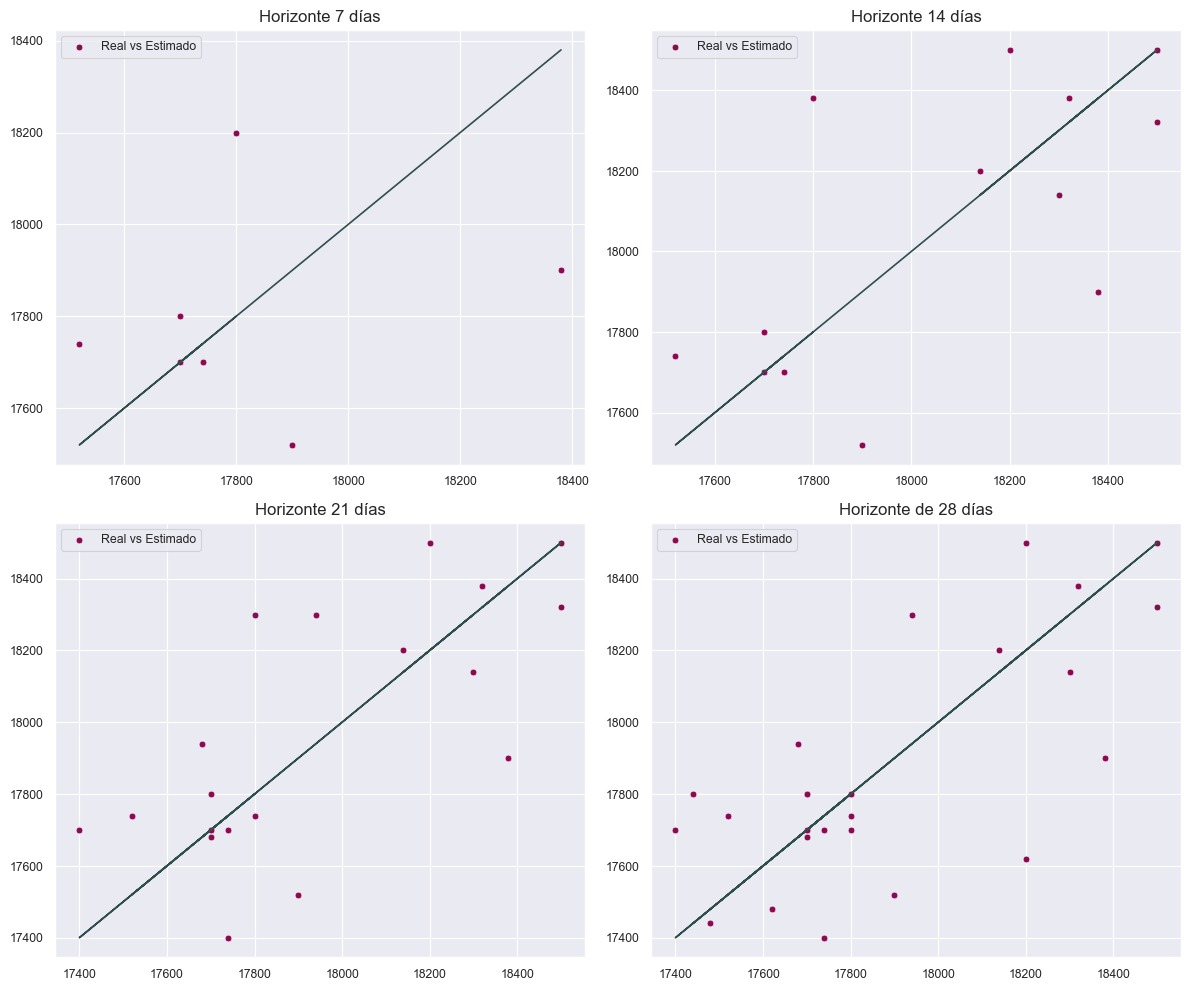

In [55]:
plt.rcParams.update({'figure.figsize' : (12 , 10)})
fig , axes = plt.subplots(nrows = 2 , ncols = 2)

# Horizonte de 7 días
sns.scatterplot(x = test7 , y = yhat7_bic , ax = axes[0 , 0] , color = '#8B0A50' , label = 'Real vs Estimado')
axes[0 , 0].plot(test7 , test7 , color = '#2F4F4F' , label = 'Correlación')
axes[0 , 0].set_title('Horizonte 7 días' , fontsize = 12)

# Horizonte de 14 días
sns.scatterplot(x = test14 , y = yhat14_bic , ax = axes[0 , 1] , color = '#8B0A50' , label = 'Real vs Estimado')
axes[0 , 1].plot(test14 , test14 , color = '#2F4F4F' , label = 'Correlación')
axes[0 , 1].set_title('Horizonte 14 días' , fontsize = 12)

# Horizonte de 21 días
sns.scatterplot(x = test21 , y = yhat21_bic , ax = axes[1 , 0] , color = '#8B0A50' , label = 'Real vs Estimado')
axes[1 , 0].plot(test21 , test21 , color = '#2F4F4F' , label = 'Correlación')
axes[1 , 0].set_title('Horizonte 21 días' , fontsize = 12)

# Horizonte de 28 días
sns.scatterplot(x = test28 , y = yhat28_bic , ax = axes[1 , 1] , color = '#8B0A50' , label = 'Real vs Estimado')
axes[1 , 1].plot(test28 , test28 , color = '#2F4F4F' , label = 'Correlación')
axes[1 , 1].set_title('Horizonte de 28 días' , fontsize = 12)

plt.tight_layout()
plt.show()



## **Criterio HQIC**

### **Modelo ajustado**

Inicialmente, se ajustará el modelo teniendo en cuenta los mejores ordenes obtenidos anteriormente para el criterio de información de **Hannan- Quinn**

In [56]:
best_order_hqic = results['HQIC']['best_order']
model_hqic = ARIMA(train, order = best_order_hqic)
model_fit_hqic = model_hqic.fit()

La siguiente gráfica representa la predicción realizada utilizando el modelo ARIMA ajustado al conjunto de datos de entrenamiento y al mejor orden obtenido para el criterio HQIC

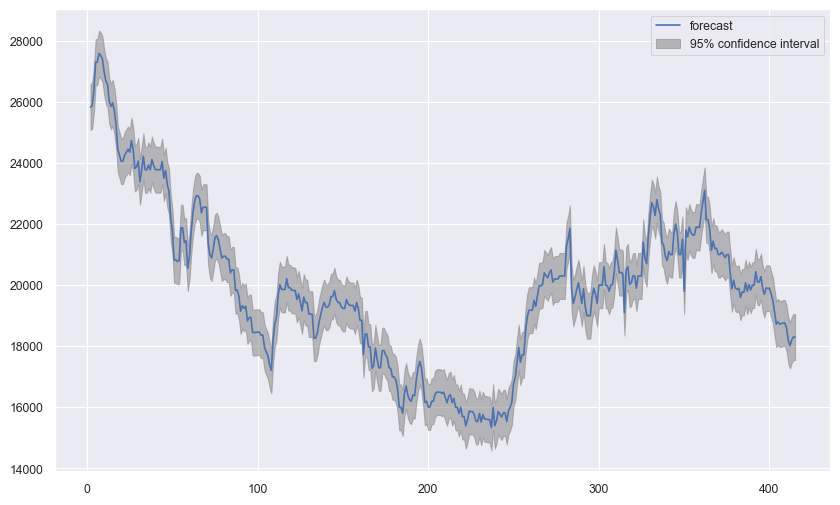

In [57]:
plt.rcParams.update({'figure.figsize': (10,6)})
plot_predict(model_fit_hqic, 2);
# El valor 2 significa que la predicción comenzará desde la segunda observación.
plt.show();

Al ver la gráfica notamos que la cobertura que abarca el intervalo de confianza no es muy ancha. Lo que podría indicar una buena precisión en predecir los pronósticos.

### **Modelo ARIMA con rolling forecast**

Ahora, apliquemos el modelo ARIMA con rolling forecast teniendo en cuenta los conjuntos anteriormente seleccionados y el mejor orden obtenido por el criterio HQIC

In [58]:
print('ARIMA Rolling HQIC- Horizonte de 7 días.')
yhat7_hqic = arima_rolling(train_list, test7, best_order_hqic)

print('\nARIMA Rolling HQIC - Horizonte de 14 días.')
yhat14_hqic = arima_rolling(train_list, test14, best_order_hqic)

print('\nARIMA Rolling HQIC - Horizonte de 21 días.')
yhat21_hqic = arima_rolling(train_list, test21, best_order_hqic)

print('\nARIMA Rolling HQIC - Horizonte de 28 días.')
yhat28_hqic = arima_rolling(train_list, test28, best_order_hqic)

ARIMA Rolling HQIC- Horizonte de 7 días.
predicho = 18200.000000, esperado = 17800.000000
predicho = 17800.000000, esperado = 17700.000000
predicho = 17700.000000, esperado = 17700.000000
predicho = 17700.000000, esperado = 17740.000000
predicho = 17740.000000, esperado = 17520.000000
predicho = 17520.000000, esperado = 17900.000000
predicho = 17900.000000, esperado = 18380.000000

ARIMA Rolling HQIC - Horizonte de 14 días.
predicho = 18380.000000, esperado = 17800.000000
predicho = 17800.000000, esperado = 17700.000000
predicho = 17700.000000, esperado = 17700.000000
predicho = 17700.000000, esperado = 17740.000000
predicho = 17740.000000, esperado = 17520.000000
predicho = 17520.000000, esperado = 17900.000000
predicho = 17900.000000, esperado = 18380.000000
predicho = 18380.000000, esperado = 18320.000000
predicho = 18320.000000, esperado = 18500.000000
predicho = 18500.000000, esperado = 18500.000000
predicho = 18500.000000, esperado = 18500.000000
predicho = 18500.000000, esperado

Veamos gráficamente lo anterior.

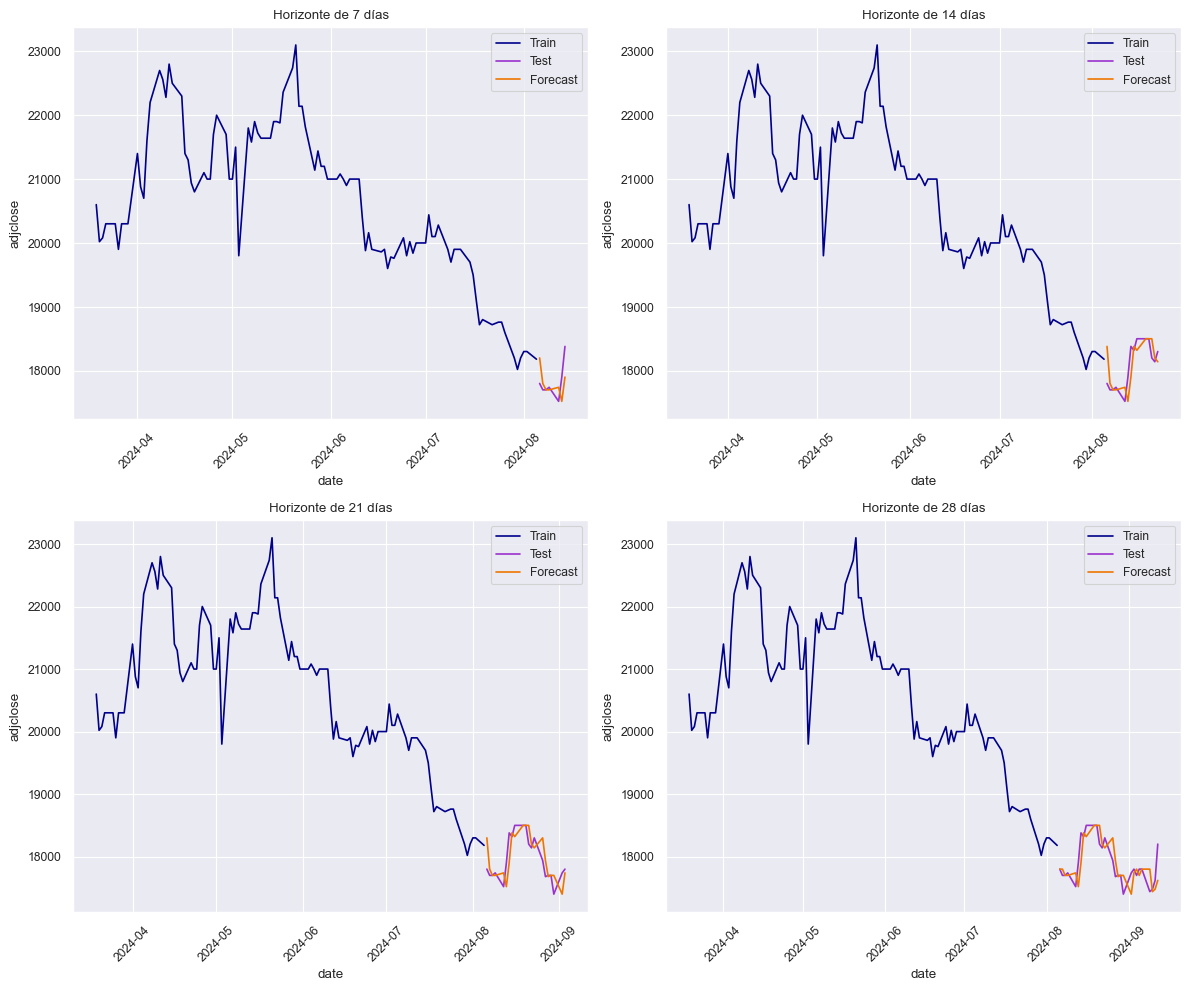

In [59]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
# -100: seleccionar los últimos 100 elementos.

# Horizonte de 7 días
sns.lineplot(ax = axs[0, 0], x = dates_train[-100:], y = train[-100:], label = 'Train', color = '#00008B')
sns.lineplot(ax = axs[0, 0], x = dates_test7, y = test7, label = 'Test', color = '#9A32CD')
sns.lineplot(ax = axs[0, 0], x = dates_test7, y = yhat7_hqic, label = 'Forecast', color = '#EE7600')
axs[0, 0].set_title('Horizonte de 7 días')
axs[0, 0].tick_params(axis = 'x', rotation = 45)

# Horizonte de 14 días
sns.lineplot(ax = axs[0, 1], x = dates_train[-100:], y = train[-100:], label = 'Train', color = '#00008B')
sns.lineplot(ax = axs[0, 1], x = dates_test14, y = test14, label = 'Test', color = '#9A32CD')
sns.lineplot(ax = axs[0, 1], x = dates_test14, y = yhat14_hqic, label = 'Forecast', color = '#EE7600')
axs[0, 1].set_title('Horizonte de 14 días')
axs[0, 1].tick_params(axis = 'x', rotation = 45)

# Horizonte de 21 días
sns.lineplot(ax = axs[1, 0], x = dates_train[-100:], y = train[-100:], label = 'Train', color = '#00008B')
sns.lineplot(ax = axs[1, 0], x = dates_test21, y = test21, label = 'Test', color = '#9A32CD')
sns.lineplot(ax = axs[1, 0], x = dates_test21, y = yhat21_hqic, label = 'Forecast', color = '#EE7600')
axs[1, 0].set_title('Horizonte de 21 días')
axs[1, 0].tick_params(axis = 'x', rotation = 45)

# Horizonte de 28 días
sns.lineplot(ax = axs[1, 1], x = dates_train[-100:], y = train[-100:], label = 'Train', color = '#00008B')
sns.lineplot(ax = axs[1, 1], x = dates_test28, y = test28, label = 'Test', color = '#9A32CD')
sns.lineplot(ax = axs[1, 1], x = dates_test28, y = yhat28_hqic, label = 'Forecast', color = '#EE7600')
axs[1, 1].set_title('Horizonte de 28 días')
axs[1, 1].tick_params(axis = 'x', rotation = 45)

plt.tight_layout()
plt.show()


### **Modelo ARIMA sin rolling forecast**

Veamos ahora el modelo ARIMA sin rolling forecast teniendo en cuenta los conjuntos anteriormente seleccionados y el mejor orden obtenido por el criterio HQIC


In [60]:
print('ARIMA sin Rolling AIC - Horizonte de 7 días.')
yhat7_sin_hqic = arima_sin_rolling(test7, model_fit_hqic)

print('\nARIMA sin Rolling AIC - Horizonte de 14 días.')
yhat14_sin_hqic = arima_sin_rolling(test14, model_fit_hqic)

print('\nARIMA sin Rolling AIC - Horizonte de 21 días.')
yhat21_sin_hqic = arima_sin_rolling(test21, model_fit_hqic)

print('\nARIMA sin Rolling AIC - Horizonte de 28 días')
yhat28_sin_hqic = arima_sin_rolling(test28, model_fit_hqic)

ARIMA sin Rolling AIC - Horizonte de 7 días.
Predicho: 18180.0, Observado: 17800.0
Predicho: 18180.0, Observado: 17700.0
Predicho: 18180.0, Observado: 17700.0
Predicho: 18180.0, Observado: 17740.0
Predicho: 18180.0, Observado: 17520.0
Predicho: 18180.0, Observado: 17900.0
Predicho: 18180.0, Observado: 18380.0

ARIMA sin Rolling AIC - Horizonte de 14 días.
Predicho: 18180.0, Observado: 17800.0
Predicho: 18180.0, Observado: 17700.0
Predicho: 18180.0, Observado: 17700.0
Predicho: 18180.0, Observado: 17740.0
Predicho: 18180.0, Observado: 17520.0
Predicho: 18180.0, Observado: 17900.0
Predicho: 18180.0, Observado: 18380.0
Predicho: 18180.0, Observado: 18320.0
Predicho: 18180.0, Observado: 18500.0
Predicho: 18180.0, Observado: 18500.0
Predicho: 18180.0, Observado: 18500.0
Predicho: 18180.0, Observado: 18200.0
Predicho: 18180.0, Observado: 18140.0
Predicho: 18180.0, Observado: 18300.0

ARIMA sin Rolling AIC - Horizonte de 21 días.
Predicho: 18180.0, Observado: 17800.0
Predicho: 18180.0, Observ

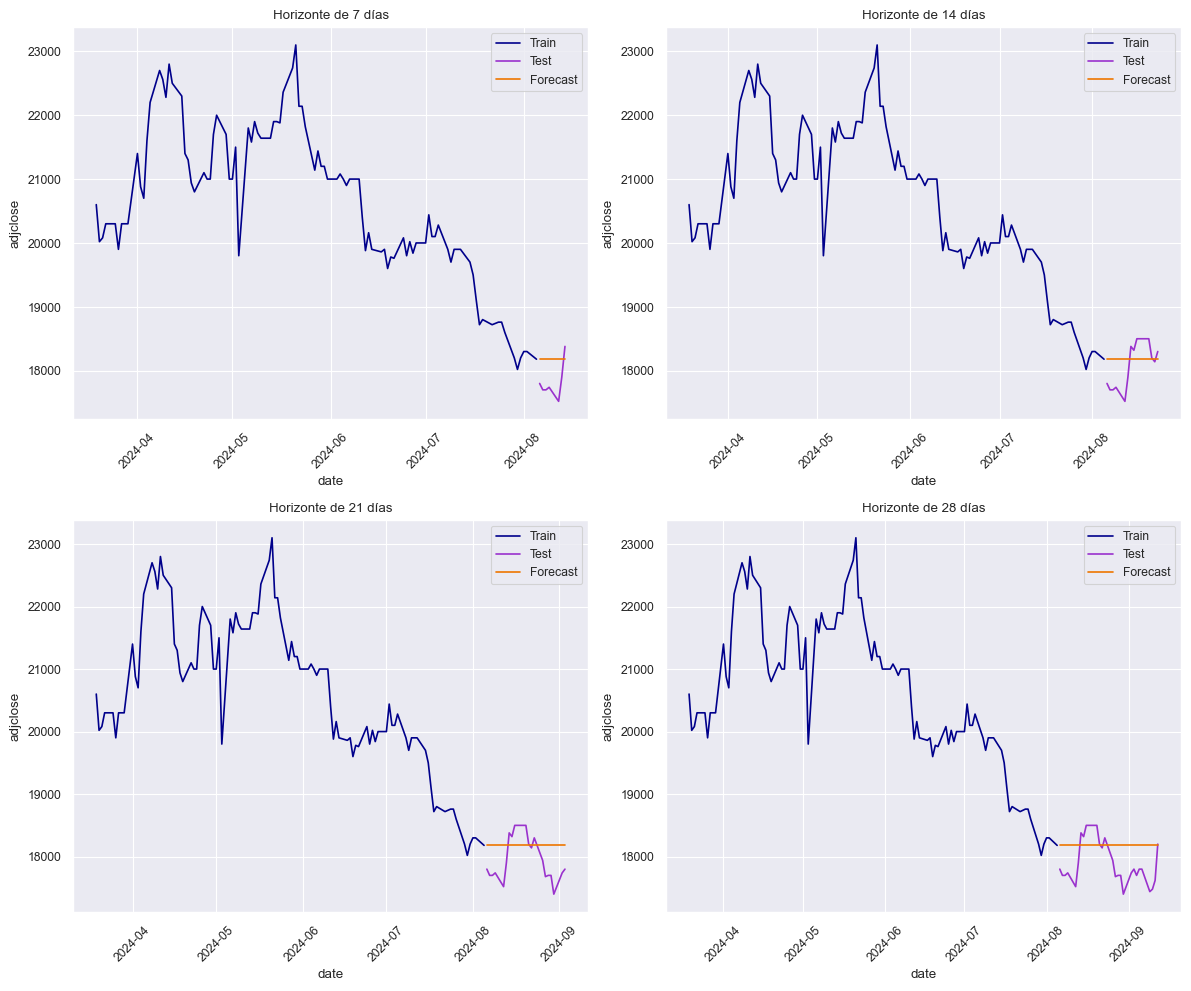

In [61]:
fig , axs = plt.subplots(2 , 2 , figsize = (12 , 10))

# Horizonte de 7 días
sns.lineplot(ax = axs[0 , 0] , x = dates_train[-100:] , y = train[-100:] , label = "Train" , color = '#00008B')
sns.lineplot(ax = axs[0 , 0] , x = dates_test7 , y = test7 , label = "Test" , color = '#9A32CD')
sns.lineplot(ax = axs[0 , 0] , x = dates_test7 , y = yhat7_sin_hqic , label = "Forecast" , color = '#EE7600')
axs[0 , 0].set_title("Horizonte de 7 días")
axs[0 , 0].tick_params(axis = 'x' , rotation = 45)

# Horizonte de 14 días
sns.lineplot(ax = axs[0 , 1] , x = dates_train[-100:] , y = train[-100:] , label = "Train" , color = '#00008B')
sns.lineplot(ax = axs[0 , 1] , x = dates_test14 , y = test14 , label = "Test" , color = '#9A32CD')
sns.lineplot(ax = axs[0 , 1] , x = dates_test14 , y = yhat14_sin_hqic , label = "Forecast" , color = '#EE7600')
axs[0 , 1].set_title("Horizonte de 14 días")
axs[0 , 1].tick_params(axis = 'x' , rotation = 45)

# Horizonte de 21 días
sns.lineplot(ax = axs[1 , 0] , x = dates_train[-100:] , y = train[-100:] , label = "Train" , color = '#00008B')
sns.lineplot(ax = axs[1 , 0] , x = dates_test21 , y = test21 , label = "Test" , color = '#9A32CD')
sns.lineplot(ax = axs[1 , 0] , x = dates_test21 , y = yhat21_sin_hqic , label = "Forecast" , color = '#EE7600')
axs[1 , 0].set_title("Horizonte de 21 días")
axs[1 , 0].tick_params(axis = 'x' , rotation = 45)

# Horizonte de 28 días
sns.lineplot(ax = axs[1 , 1] , x = dates_train[-100:] , y = train[-100:] , label = "Train" , color = '#00008B')
sns.lineplot(ax = axs[1 , 1] , x = dates_test28 , y = test28 , label = "Test" , color = '#9A32CD')
sns.lineplot(ax = axs[1 , 1] , x = dates_test28 , y = yhat28_sin_hqic , label = "Forecast" , color = '#EE7600')
axs[1 , 1].set_title("Horizonte de 28 días")
axs[1 , 1].tick_params(axis = 'x' , rotation = 45)

plt.tight_layout()
plt.show()


### **Análisis de residuos modelo ARIMA basado en el criterio HQIC**

#### **Normalidad de los residuos**

Ahora, veamos la normalidad del conjunto de datos residuales por medio de la prueba de `Shapiro-Wilk` y luego veamos gráficamente la distribución.

- **Hipótesis Nula (H₀):** La muestra parece provenir de una distribución normal.
- **Hipótesis Alternativa (H₁):** La muestra NO parece provenir de una distribución normal.

Statistic = 0.182
P-Value = 6.36202053226988e-39
Se rechaza la hipótesis nula, por lo tanto los residuales no siguen una distribución normal.


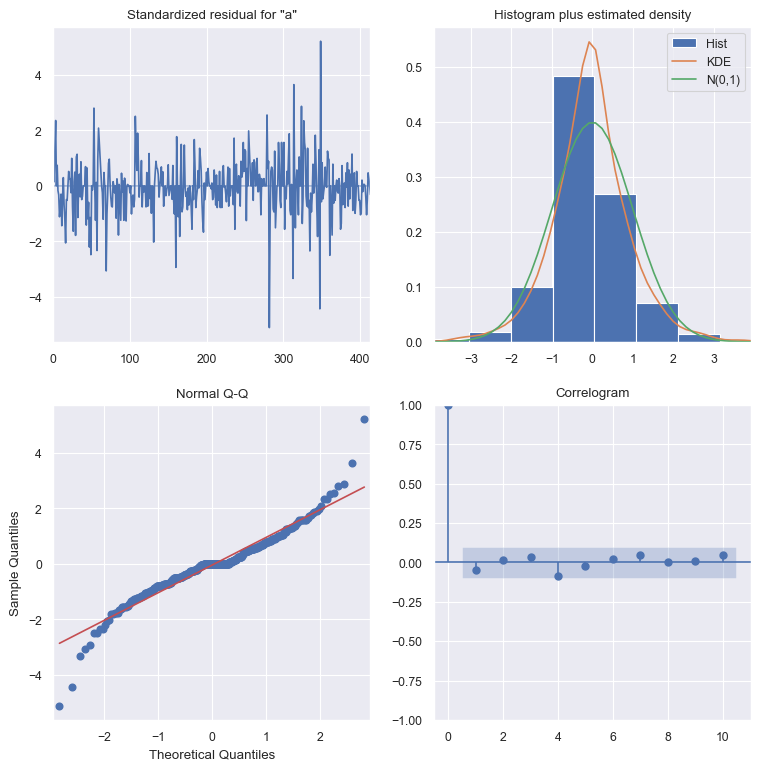

In [62]:
qq3 = model_fit_hqic.plot_diagnostics(figsize=(9,9))

stat3, pvalue3 = shapiro(model_fit_hqic.resid)
print(f'Statistic = {stat3:.3f}')
print(f'P-Value = {pvalue3}')
if(pvalue3 < 0.05):
    print('Se rechaza la hipótesis nula, por lo tanto los residuales no siguen una distribución normal.')
else:
    print('No se rechaza la hipótesis nula, por lo tanto los residuales siguen una distribución normal.')

#### **Independencia de los residuos**

Uno de los principales supuestos de los modelos es que NO existe autocorrelación entre los residuos. Se usará la prueba de `Durbin-Watson`, teniendo en cuenta las siguientes hipótesis.


- **Hipótesis Nula (H₀):** No existe correlación entre los residuos
- **Hipótesis Alternativa (H₁):** Los residuos están correlacionados

Usaremos el estadístico de prueba para determinar si hay o no autocorrelación entre los residuos, dado que la prueba en sí no da un p-valor en su cálculo

Si:
- d = 2, NO hay autocorrelación
- d < 2, correlación positiva
- d > 2, correlación negativa.

In [63]:
dw3 = durbin_watson(model_fit_hqic.resid)

print(f'Statistic d = {dw3:.3f}')
if(dw3 < 1.5 or dw3 > 2.5):
    print('Se rechaza la hipótesis nula, los residuales están correlacionados.')
else:
    print('No se rechaza la hipótesis nula, no existe correlación entre los residuales.')

Statistic d = 1.087
Se rechaza la hipótesis nula, los residuales están correlacionados.


### **Comparación de modelos - Criterio HQIC**




#### **Tablas de error**

Veamos las tablas de error tanto para el modelo ARIMA con y sin rolling forecast teniendo en cuenta el criterio HQIC

In [64]:
accuracy7_hqic =  forecast_accuracy(np.array(test7), np.array(yhat7_hqic), "7 días")
accuracy14_hqic = forecast_accuracy(np.array(test14), np.array(yhat14_hqic), "14 días")
accuracy21_hqic = forecast_accuracy(np.array(test21), np.array(yhat21_hqic), "21 días")
accuracy28_hqic = forecast_accuracy(np.array(test28), np.array(yhat28_hqic), "28 días")

accuracy_rolling3 = pd.concat([accuracy7_hqic, accuracy14_hqic, accuracy21_hqic, accuracy28_hqic])

In [65]:
accuracy7_not_hqic = forecast_accuracy(np.array(test7), np.array(yhat7_sin_hqic), "7 días")
accuracy14_not_hqic = forecast_accuracy(np.array(test14), np.array(yhat14_sin_hqic), "14 días")
accuracy21_not_hqic = forecast_accuracy(np.array(test21), np.array(yhat21_sin_hqic), "21 días")
accuracy28_not_hqic = forecast_accuracy(np.array(test28), np.array(yhat28_sin_hqic), "28 días")

accuracy_not_rolling3 = pd.concat([ accuracy7_not_hqic, accuracy14_not_hqic, accuracy21_not_hqic, accuracy28_not_hqic])

In [66]:
accuracy_rolling3

,MAE,MSE,MAPE,RMSE,R2
7 días,231.428571,84971.428571,0.012966,291.498591,-0.334829
14 días,182.857143,66171.428571,0.010126,257.238078,0.410516
21 días,181.904762,59371.428571,0.010128,243.662530,0.479285
28 días,165.714286,53714.285714,0.009289,231.763426,0.512701


In [67]:
accuracy_not_rolling3

,MAE,MSE,MAPE,RMSE,R2
7 días,417.142857,193257.142857,0.022945,439.610217,-2.035907
14 días,300.000000,121142.857143,0.016502,348.055825,-0.079194
21 días,357.142857,162419.047619,0.019645,403.012466,-0.424490
28 días,384.285714,188628.571429,0.021138,434.313909,-0.711249


#### **Gráficos de correlación**

En esta parte, se puede observar los gráficos de correlación entre la observación real y su predicción en el test para cada uno de los horizontes, teniendo en cuenta el criterio HQIC y el uso de rolling forecasting.


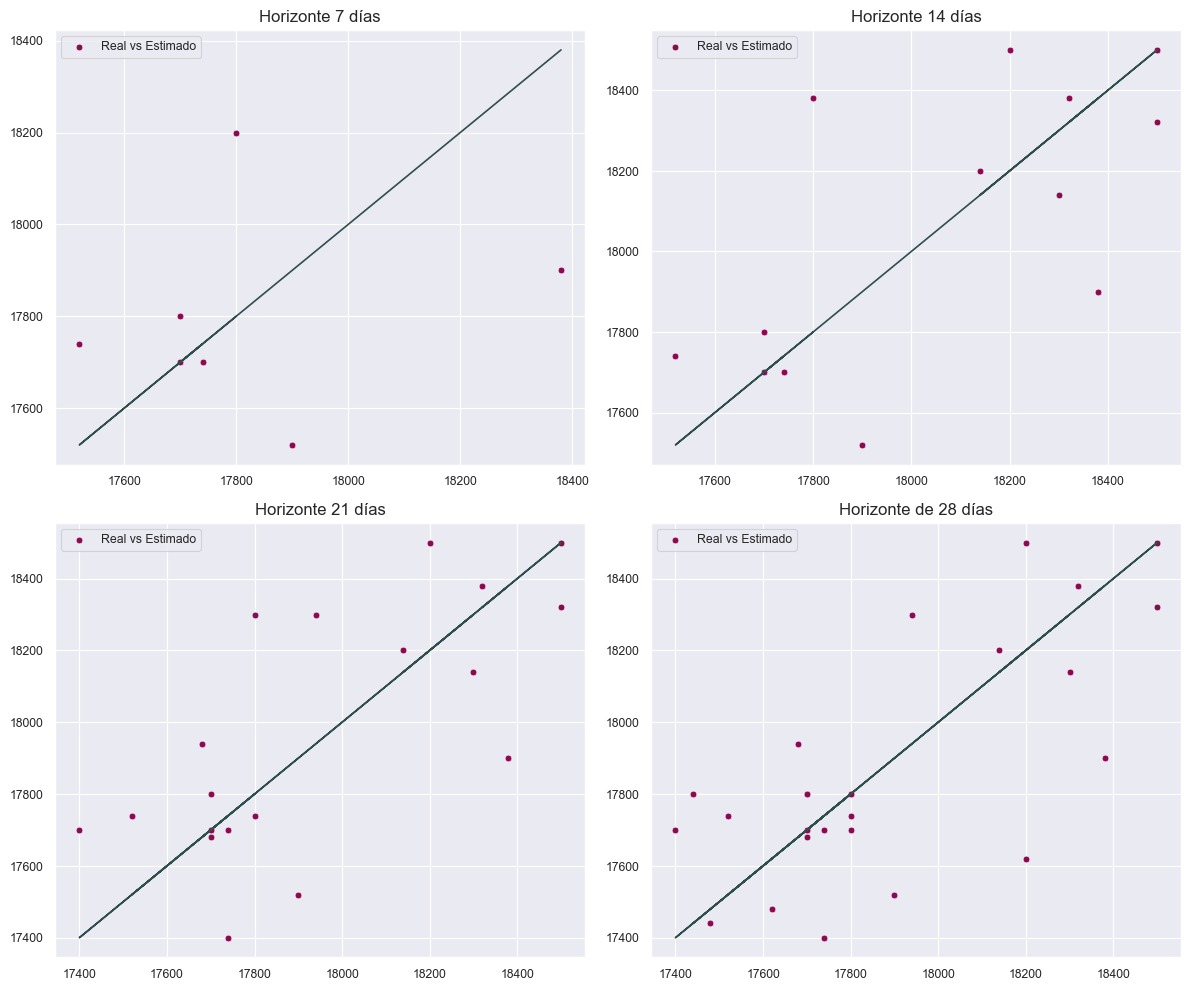

In [68]:
plt.rcParams.update({'figure.figsize' : (12 , 10)})
fig , axes = plt.subplots(nrows = 2 , ncols = 2)

# Horizonte de 7 días
sns.scatterplot(x = test7 , y = yhat7_hqic , ax = axes[0 , 0] , color = '#8B0A50' , label = 'Real vs Estimado')
axes[0 , 0].plot(test7 , test7 , color = '#2F4F4F' , label = 'Correlación')
axes[0 , 0].set_title('Horizonte 7 días' , fontsize = 12)

# Horizonte de 14 días
sns.scatterplot(x = test14 , y = yhat14_hqic , ax = axes[0 , 1] , color = '#8B0A50' , label = 'Real vs Estimado')
axes[0 , 1].plot(test14 , test14 , color = '#2F4F4F' , label = 'Correlación')
axes[0 , 1].set_title('Horizonte 14 días' , fontsize = 12)

# Horizonte de 21 días
sns.scatterplot(x = test21 , y = yhat21_hqic , ax = axes[1 , 0] , color = '#8B0A50' , label = 'Real vs Estimado')
axes[1 , 0].plot(test21 , test21 , color = '#2F4F4F' , label = 'Correlación')
axes[1 , 0].set_title('Horizonte 21 días' , fontsize = 12)

# Horizonte de 28 días
sns.scatterplot(x = test28 , y = yhat28_hqic , ax = axes[1 , 1] , color = '#8B0A50' , label = 'Real vs Estimado')
axes[1 , 1].plot(test28 , test28 , color = '#2F4F4F' , label = 'Correlación')
axes[1 , 1].set_title('Horizonte de 28 días' , fontsize = 12)

plt.tight_layout()
plt.show()



## **Conclusiones**

Aunque los resultados obtenidos con el criterio de Akaike (AIC) mostraron un mejor ajuste del modelo en comparación con otros criterios, como el BIC o el HQIC, los modelos aún no lograron generar predicciones precisas. Las métricas, como el coeficiente de determinación (R2), indican que el ajuste a los datos de la serie temporal es insuficiente. Además, las pruebas de normalidad de los residuos sugieren que no siguen una distribución normal, lo que pone en duda la confiabilidad de las predicciones.